# First we are going to experiment with the simulation and see how it performs via NLM
# Gaussian noise 

/var/folders/vl/tld4y4295dvbpfhgzk8mrvkc0000gn/T/ipykernel_31800/3008763880.py:125: UserWarning: image is size 3 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  sigma_est = np.mean(estimate_sigma(noisy_image))


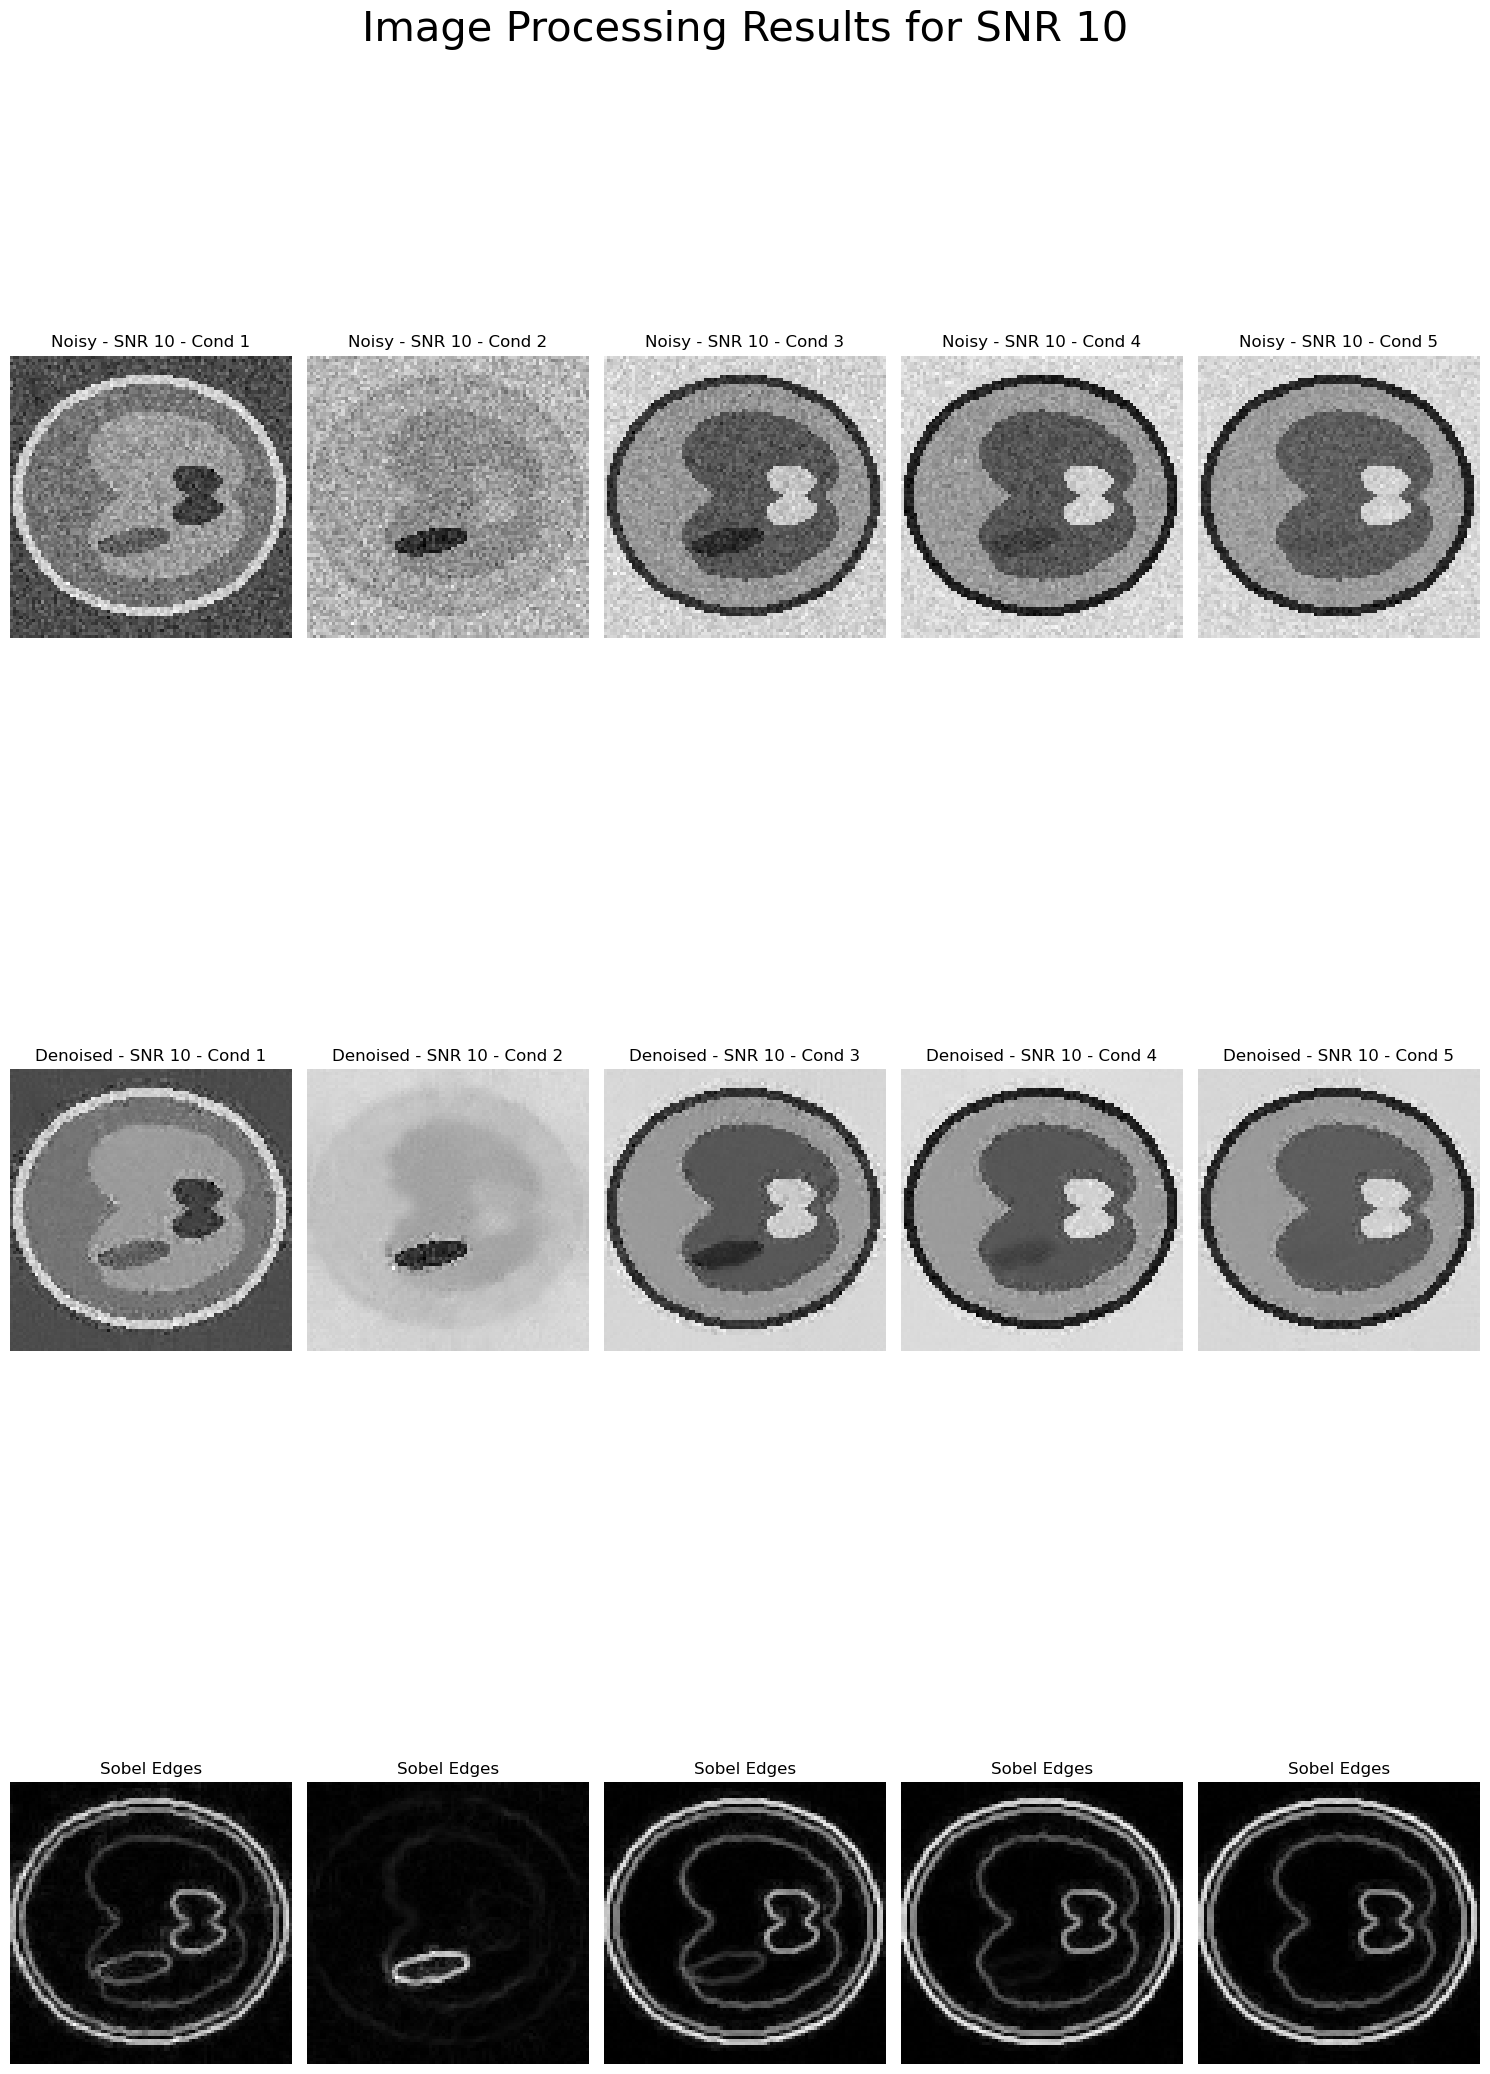

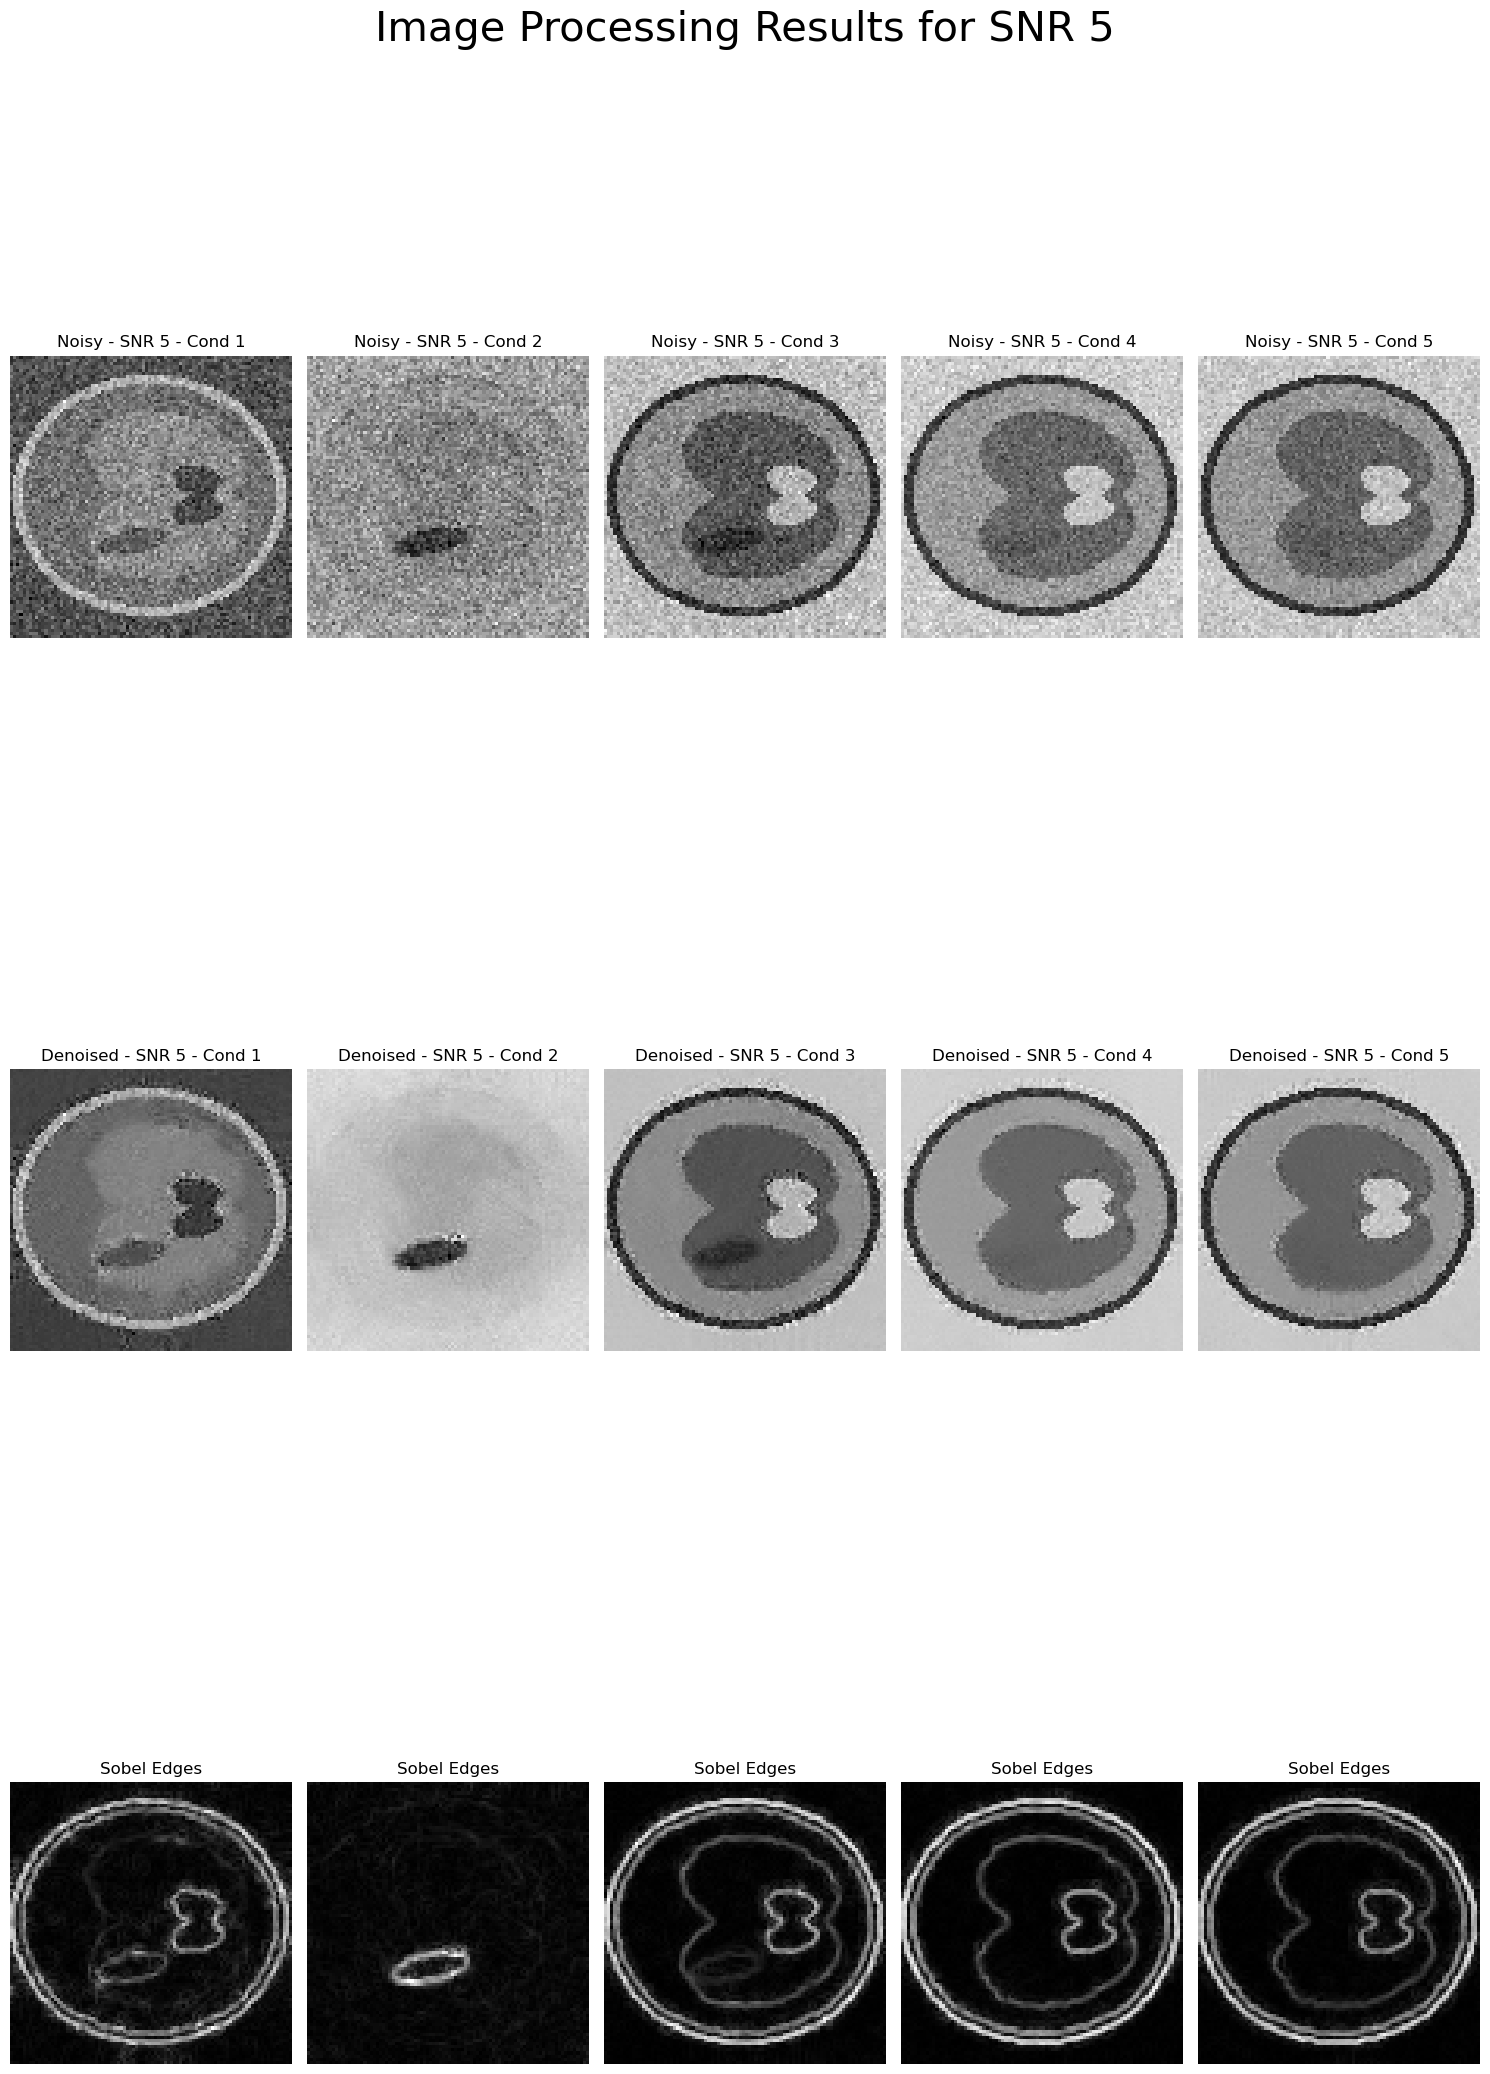

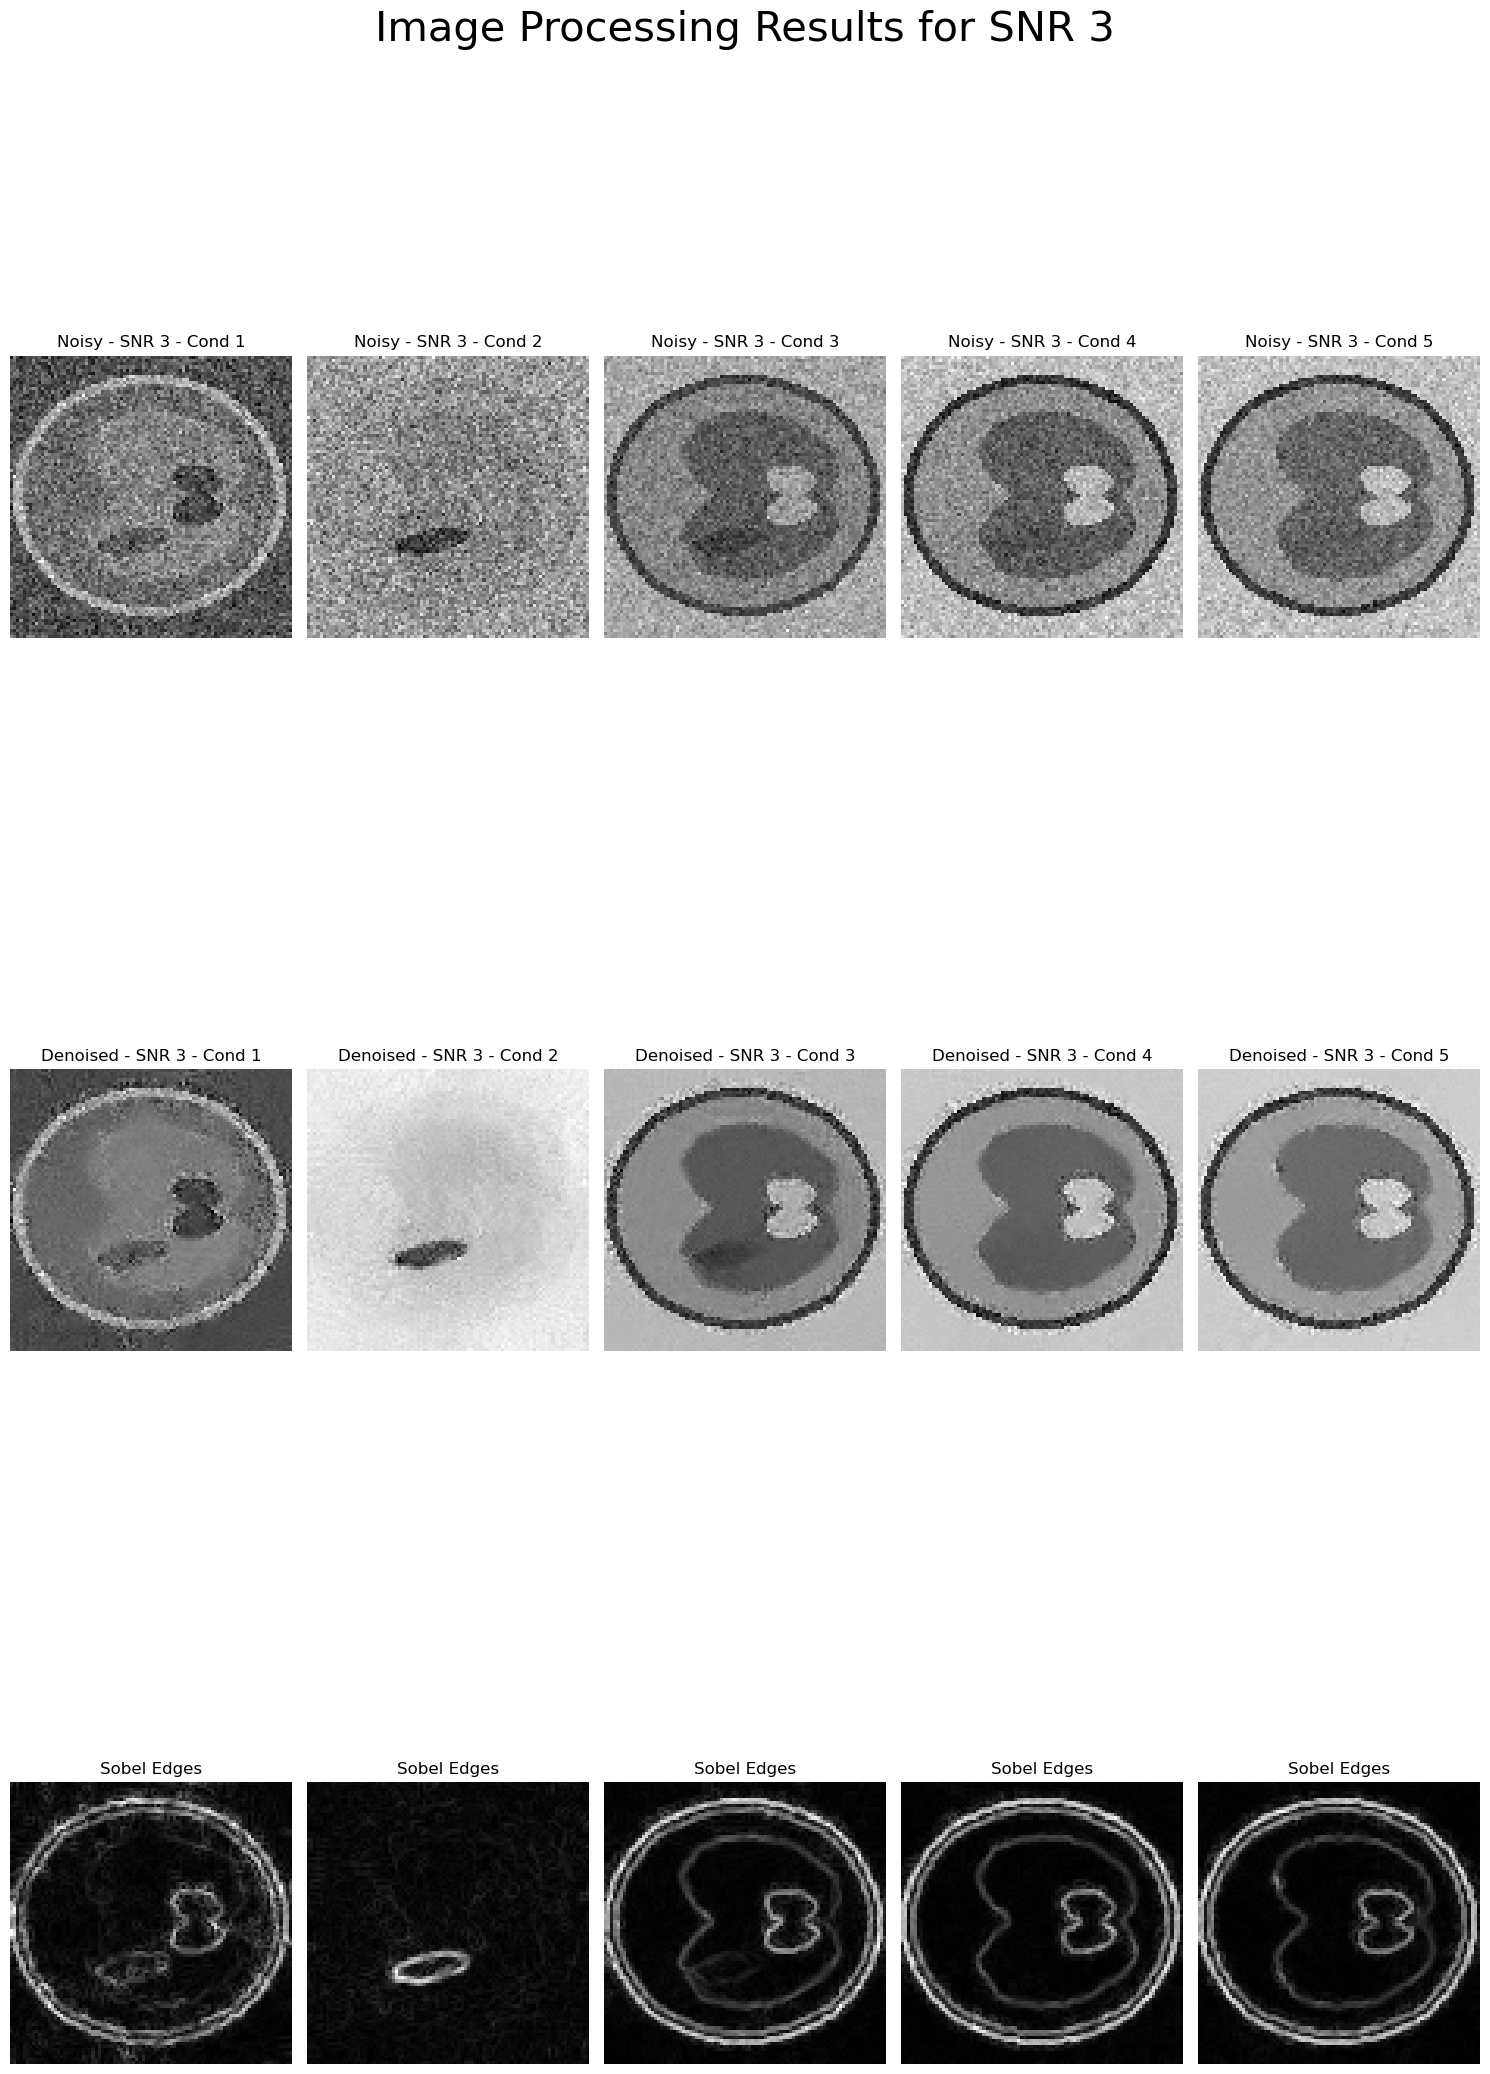

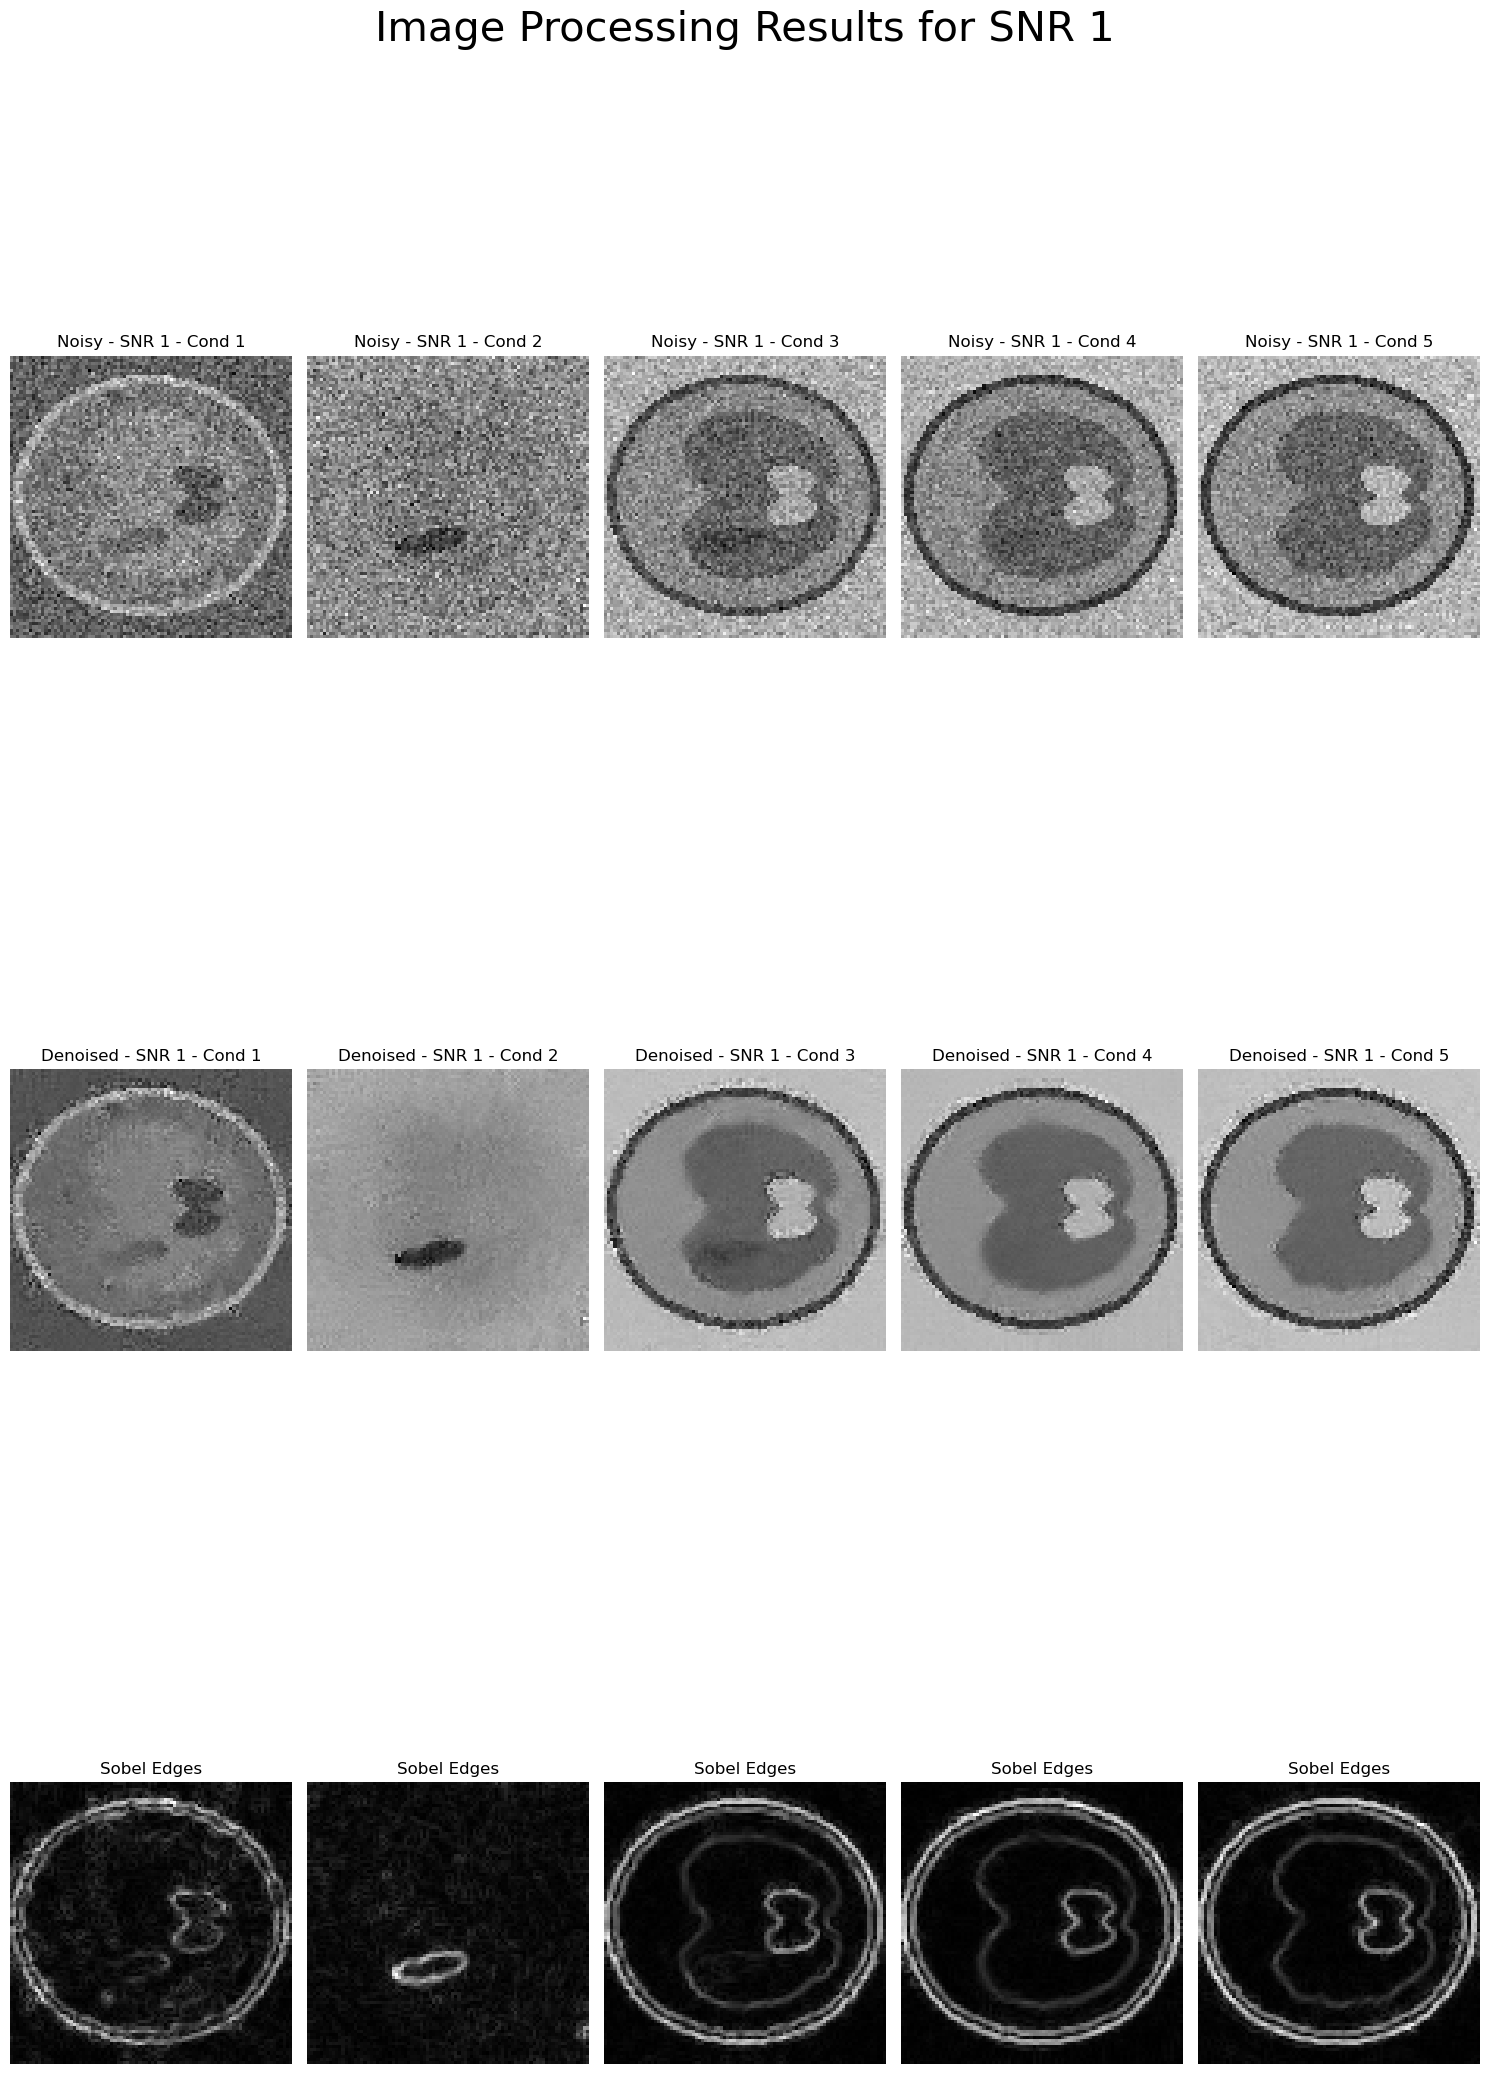

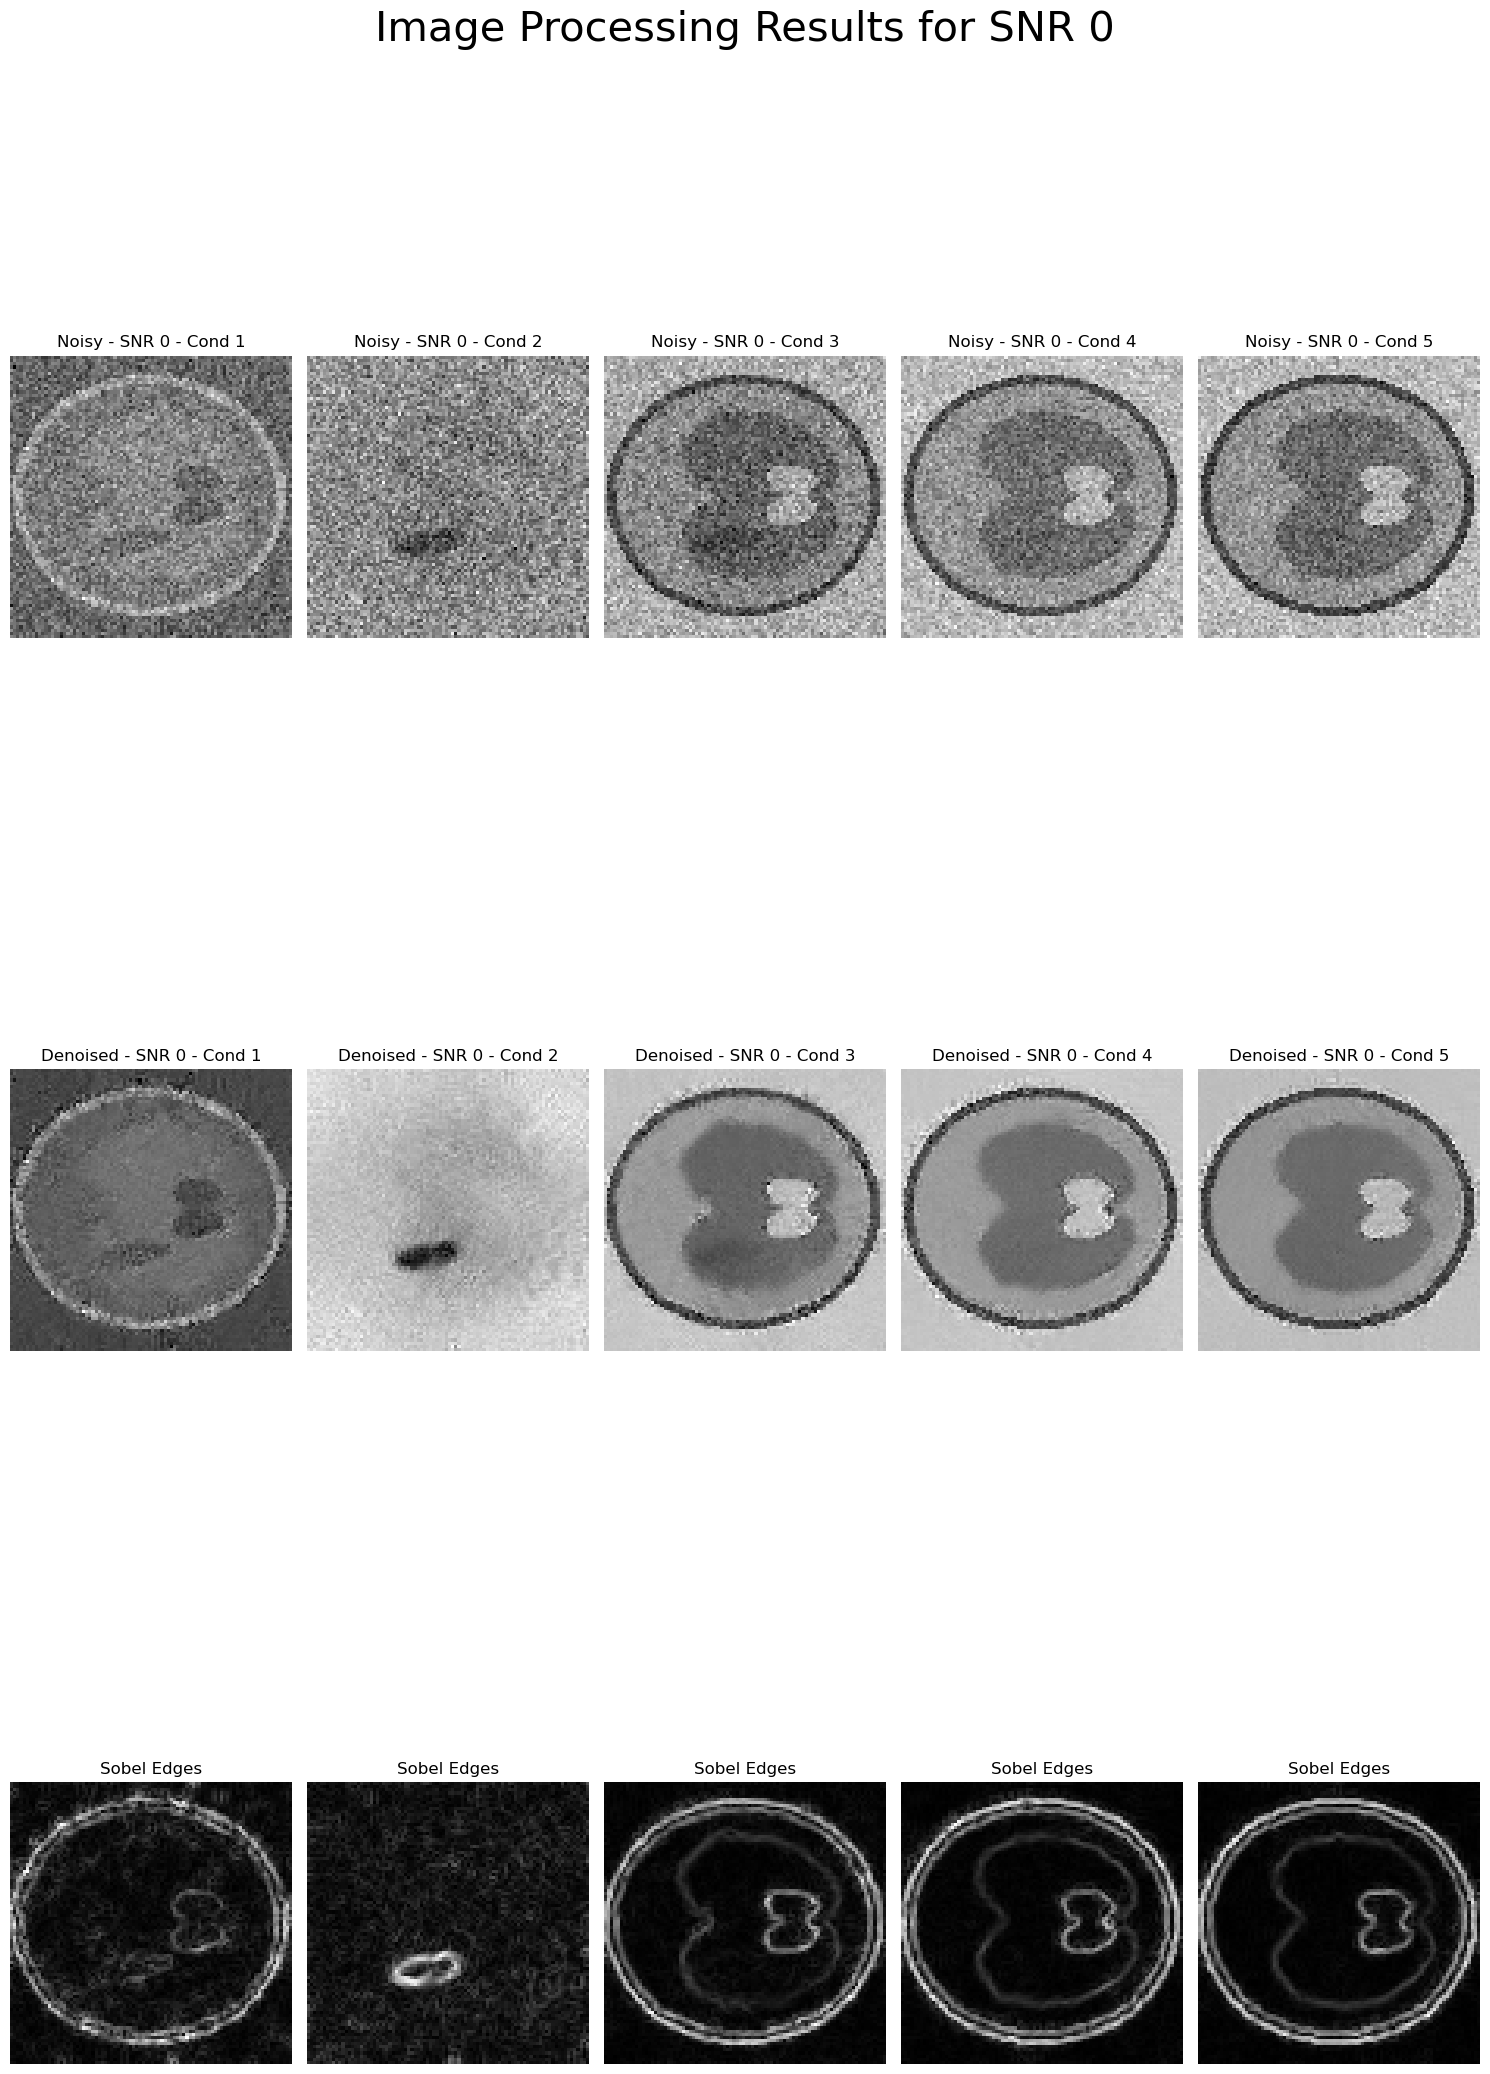

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import estimate_sigma, denoise_nl_means
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from scipy.stats import entropy as scipy_entropy
from skimage.filters import laplace
from skimage.color import rgb2gray
from skimage.filters import sobel
import seaborn as sns
import scipy.io
import scipy.io


# Define the specific SNRs to display
snrs = [10, 5, 3, 1, 0]  

def create_background_mask(image_gray):
    # Use Otsu's method to automatically determine a threshold for binarization
    thresh = threshold_otsu(image_gray)

    # Binarize the image based on the determined threshold
    binary_image = image_gray <= thresh

    # Remove small objects and clear borders
    cleared_image = clear_border(binary_image)

    # Label connected components
    label_image = label(cleared_image)

    # Find properties of labeled regions
    regions = regionprops(label_image)

    # Find the largest region (assuming it's the background)
    largest_area = 0
    background_label = 0
    for region in regions:
        if region.area > largest_area:
            largest_area = region.area
            background_label = region.label

    # Create a mask for the background region
    background_mask = label_image == background_label

    return background_mask

def adjust_denoising_parameters(sigma_est):
    if sigma_est <= 15:
        return 0.6 * sigma_est, 7, 11  # h, patch_size, patch_distance
    elif sigma_est <= 30:
        return 0.9 * sigma_est, 5, 6
    elif sigma_est <= 50:
        return 0.2 * sigma_est, 9, 17
    else:
        return 0.4 * sigma_est, 11, 23

def compute_nr_iqa(image):
    """
    Calculates no-reference image quality assessment (NR-IQA) features for a given image.

    Args:
        image (np.ndarray): The grayscale image for which to calculate NR-IQA features.

    Returns:
        dict: A dictionary containing the calculated NR-IQA features:
            - Standard Deviation: Standard deviation of pixel intensity values.
            - Laplacian Variance: Variance of the Laplacian filter applied to the image.
            - Contrast (Michelson): Michelson contrast measure based on minimum and maximum intensities.
            - Entropy: Image entropy calculated using skimage.metrics.entropy.
    """

    std_dev = np.std(image)
    laplacian_img = laplace(image, ksize=7)  # Apply the Laplacian filter
    laplacian_var = np.var(laplacian_img)  # Compute the variance of the Laplacian
    edges = sobel(image)

    contrast = (np.max(image) - np.min(image)) / (np.max(image) + np.min(image))
    # Calculate global entropy
    hist, _ = np.histogram(image, bins=256, range=(0, 256))
    prob_dist = hist / np.sum(hist)
    entropy_val = scipy_entropy(prob_dist, base=2)

    return {
        'Standard Deviation': std_dev,
        'Laplacian Variance': laplacian_var,
        'Contrast (Michelson)': contrast,
        'Entropy': entropy_val,
        'Sobel':edges
    }



for snr in snrs:
 
    # Load the MAT file
    mat = scipy.io.loadmat(f'/Users/dolorious/Downloads/simulation-1/GroundTruth_gaussian_SNR{snr}.mat')
    mat_ground_truth = scipy.io.loadmat(f'/Users/dolorious/Downloads/simulation-1/GroundTruth.mat')

    ground_truth_data = mat_ground_truth['data']
    noisy_image_data = mat['data_gaussian']
    
    # Assuming this represents different conditions
    conditions = noisy_image_data.shape[2]
    # Adjust the figure size as needed
    plt.figure(figsize=(15, conditions * 5))

    for j in range(conditions):
        # Extract the noisy image for the jth condition.
        noisy_image = noisy_image_data[:, :, j].squeeze()
        ground_truth= ground_truth_data[:, :, j]
        
        
        # Check if the image has three channels (RGB), and convert to grayscale if so
        if noisy_image.ndim == 3 and noisy_image.shape[2] == 3:
            noisy_image_gray = noisy_image.mean(axis=2)
        else:
            # If the image is already grayscale or doesn't meet the RGB shape assumption
            noisy_image_gray = noisy_image

        # Estimate the noise standard deviation from the image
        sigma_est = np.mean(estimate_sigma(noisy_image))

        # Dynamically adjust denoising parameters based on estimated noise level
        h, patch_size, patch_distance = adjust_denoising_parameters(sigma_est)

        # Create a mask to isolate the background
        background_mask = create_background_mask(noisy_image_gray)

        # Calculate the standard deviation of background pixels
        std_deviation = np.std(noisy_image_gray[background_mask])
        
        ground_truth_gray = rgb2gray(ground_truth)

        # Apply Non-Local Means Denoising with dynamically adjusted parameters
        denoised_image = denoise_nl_means(noisy_image_gray, h=h, patch_size=patch_size,
                                          patch_distance=patch_distance)
        
        
        image_ssim = ssim(ground_truth_gray, denoised_image, data_range=1.0)
        image_psnr = psnr(ground_truth_gray, denoised_image)
        image_mse = mse(ground_truth_gray, denoised_image)
        nr_iqa_metrics = compute_nr_iqa(denoised_image)
         # Compute Sobel edges
        edges = sobel(denoised_image)
        
        # Plotting
        plt.subplot(3, conditions, j + 1)
        plt.imshow(noisy_image_gray, cmap='gray')
        plt.title(f'Noisy - SNR {snr} - Cond {j+1}')
        plt.axis('off')

        plt.subplot(3, conditions, conditions + j + 1)
        plt.imshow(denoised_image, cmap='gray')
        plt.title(f'Denoised - SNR {snr} - Cond {j+1}')
        plt.axis('off')

        plt.subplot(3, conditions, 2 * conditions + j + 1)
        plt.imshow(edges, cmap='gray')
        plt.title('Sobel Edges')
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle(f'Image Processing Results for SNR {snr}', fontsize=30)
    plt.show()





# This is our Ground Truth

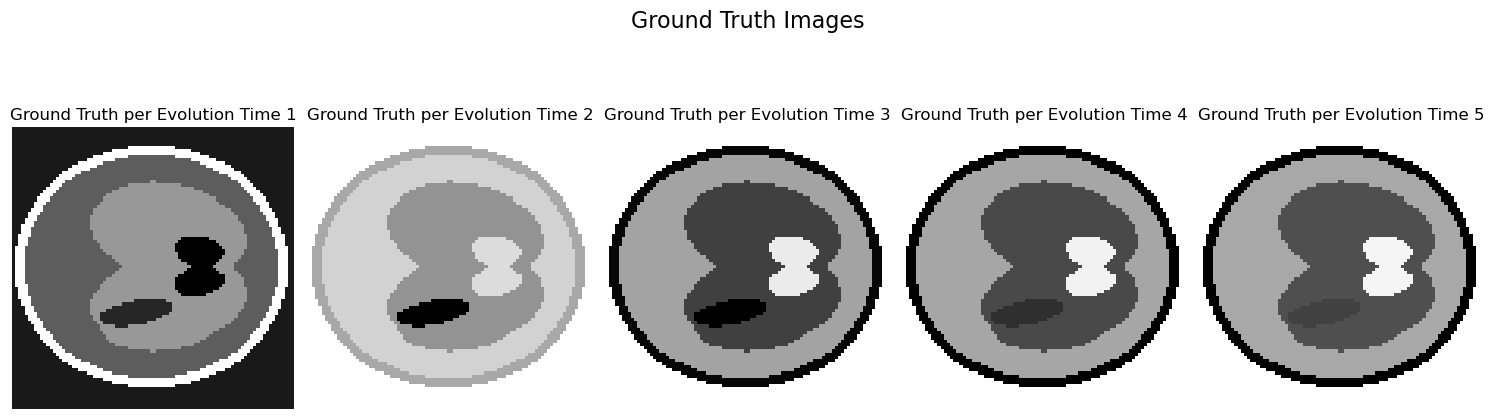

In [16]:
plt.figure(figsize=(15, 5))  # Adjust the figure size as needed.
for j in range(conditions):
    ground_truth = ground_truth_data[:, :, j]
    ground_truth_gray = rgb2gray(ground_truth) if ground_truth.ndim == 3 else ground_truth

    plt.subplot(1, conditions, j + 1)
    plt.imshow(ground_truth_gray, cmap='gray')
    plt.title(f'Ground Truth per Evolution Time {j+1}')
    plt.axis('off')

plt.suptitle('Ground Truth Images', fontsize=16)
plt.tight_layout()
plt.show()


/var/folders/vl/tld4y4295dvbpfhgzk8mrvkc0000gn/T/ipykernel_7383/4220126779.py:30: UserWarning: image is size 3 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  sigma_est = np.mean(estimate_sigma(noisy_image))


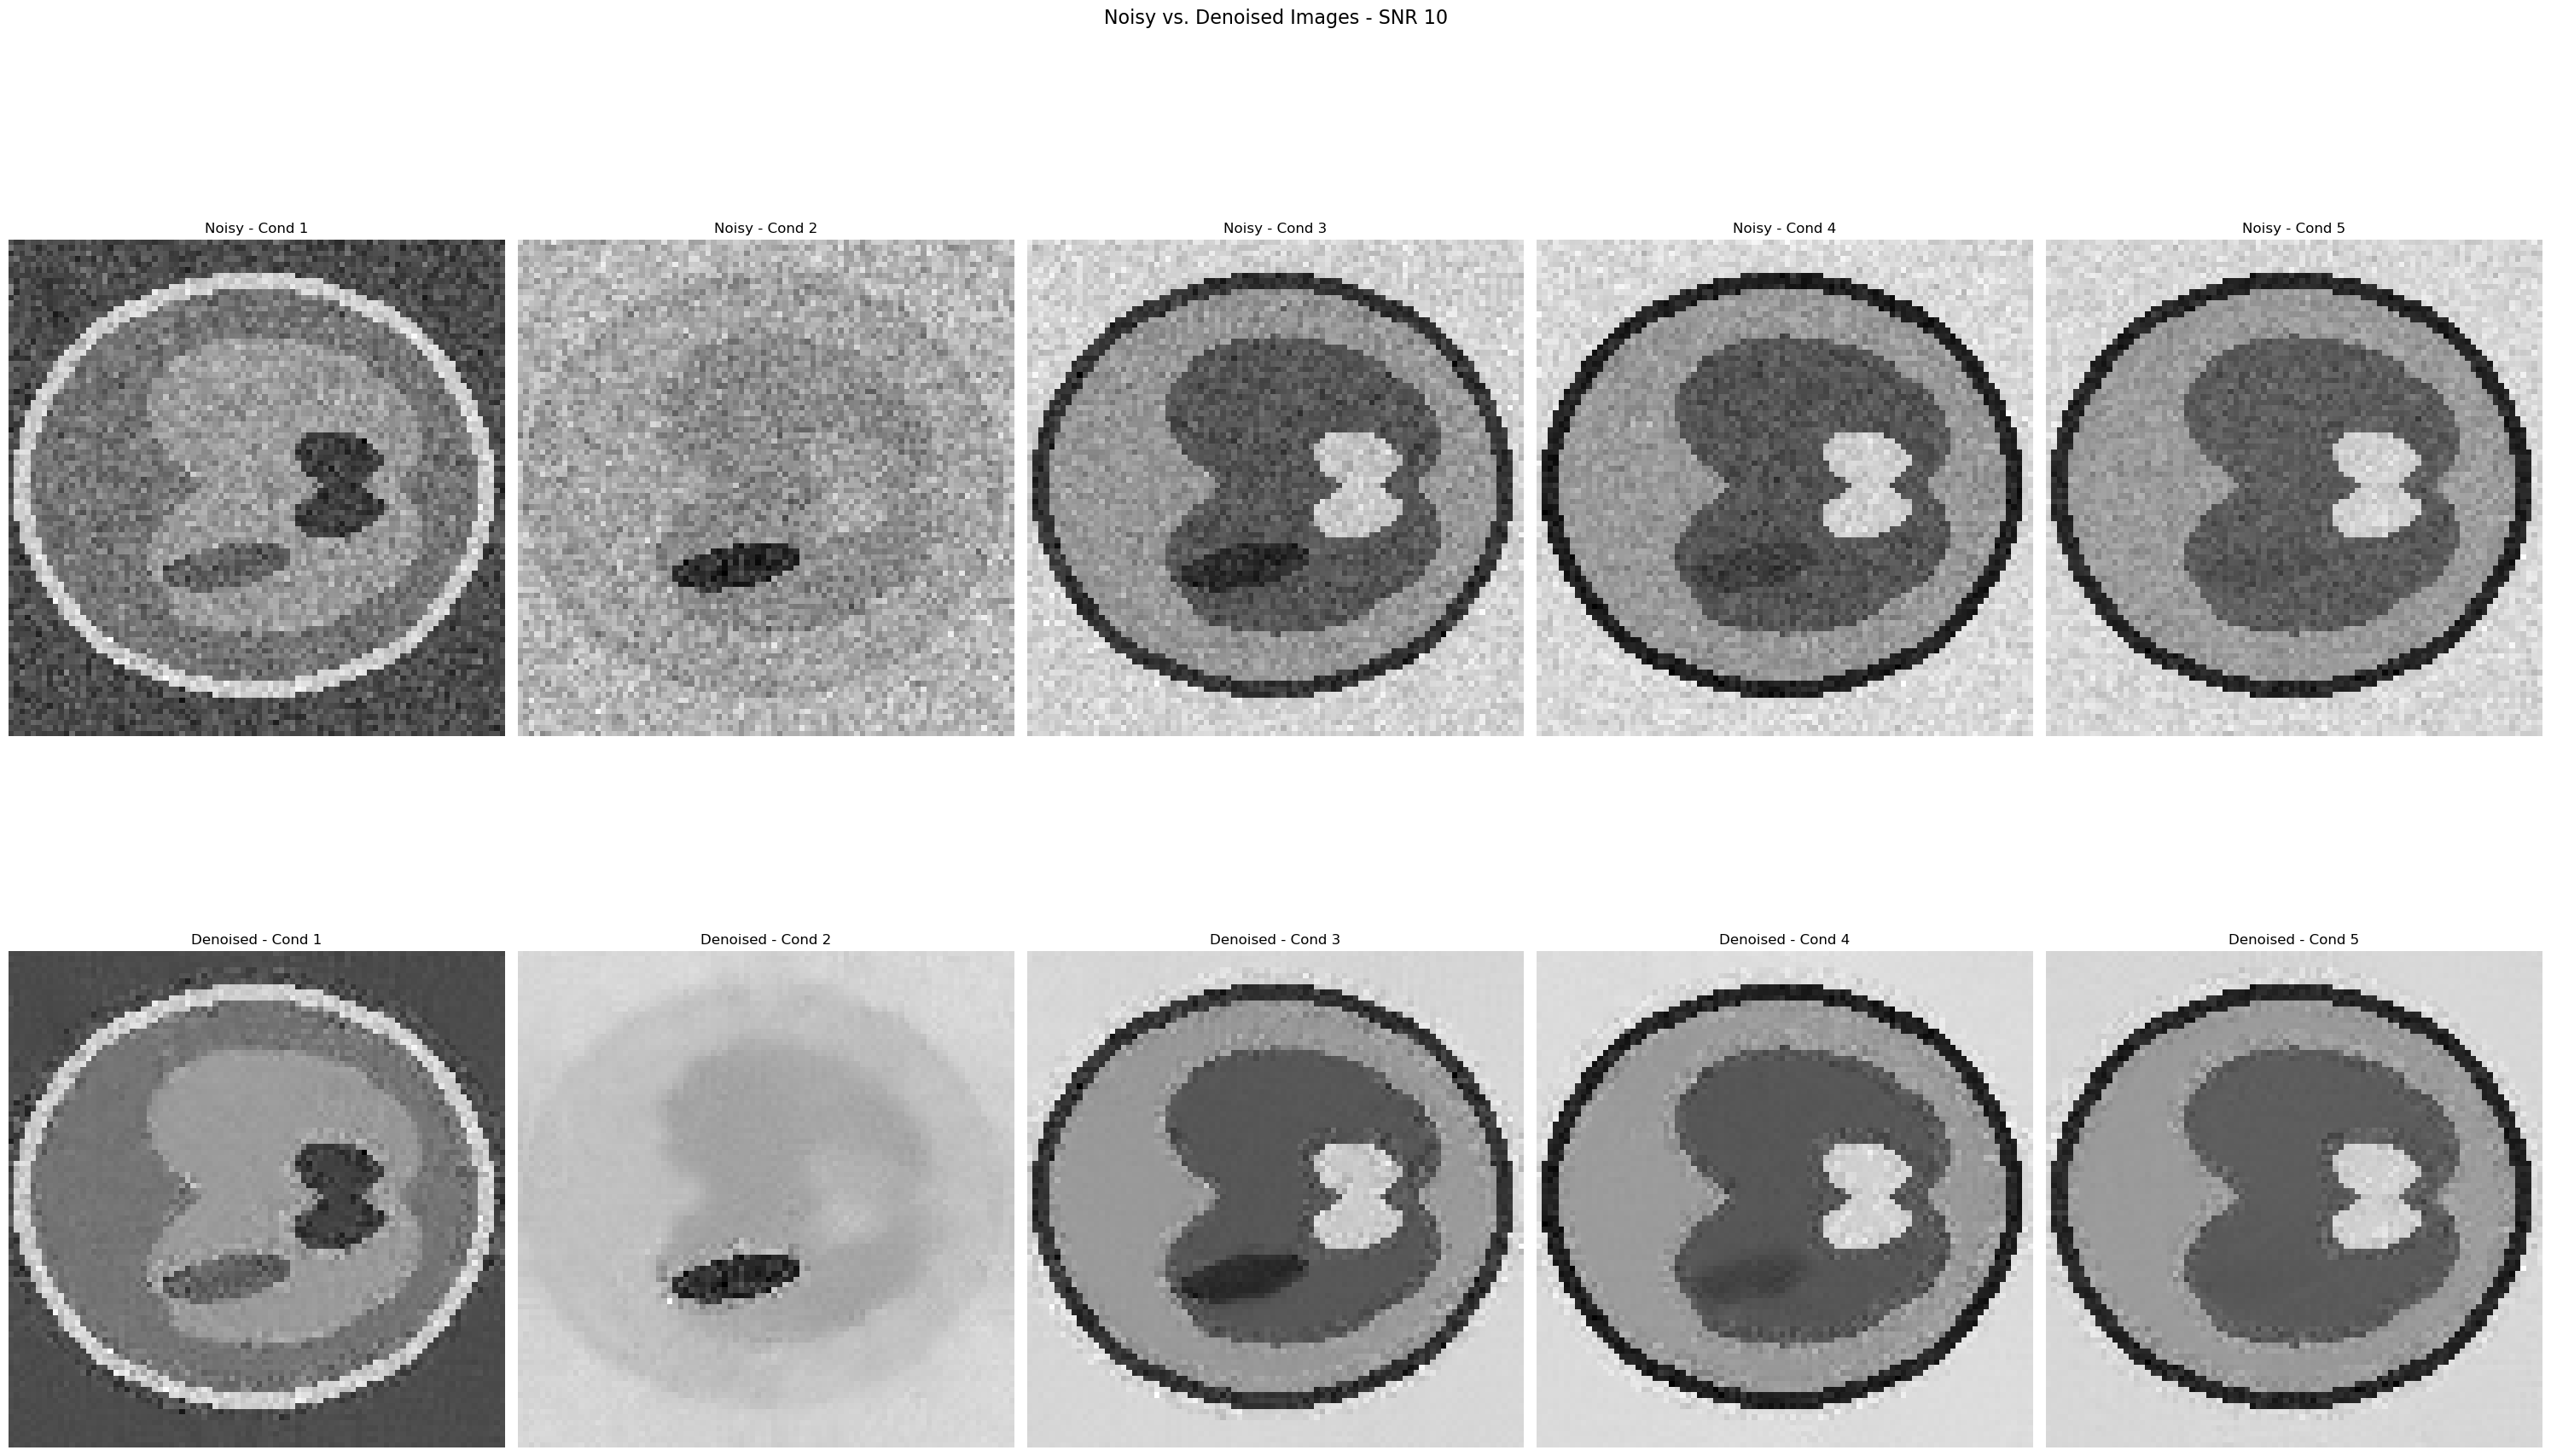

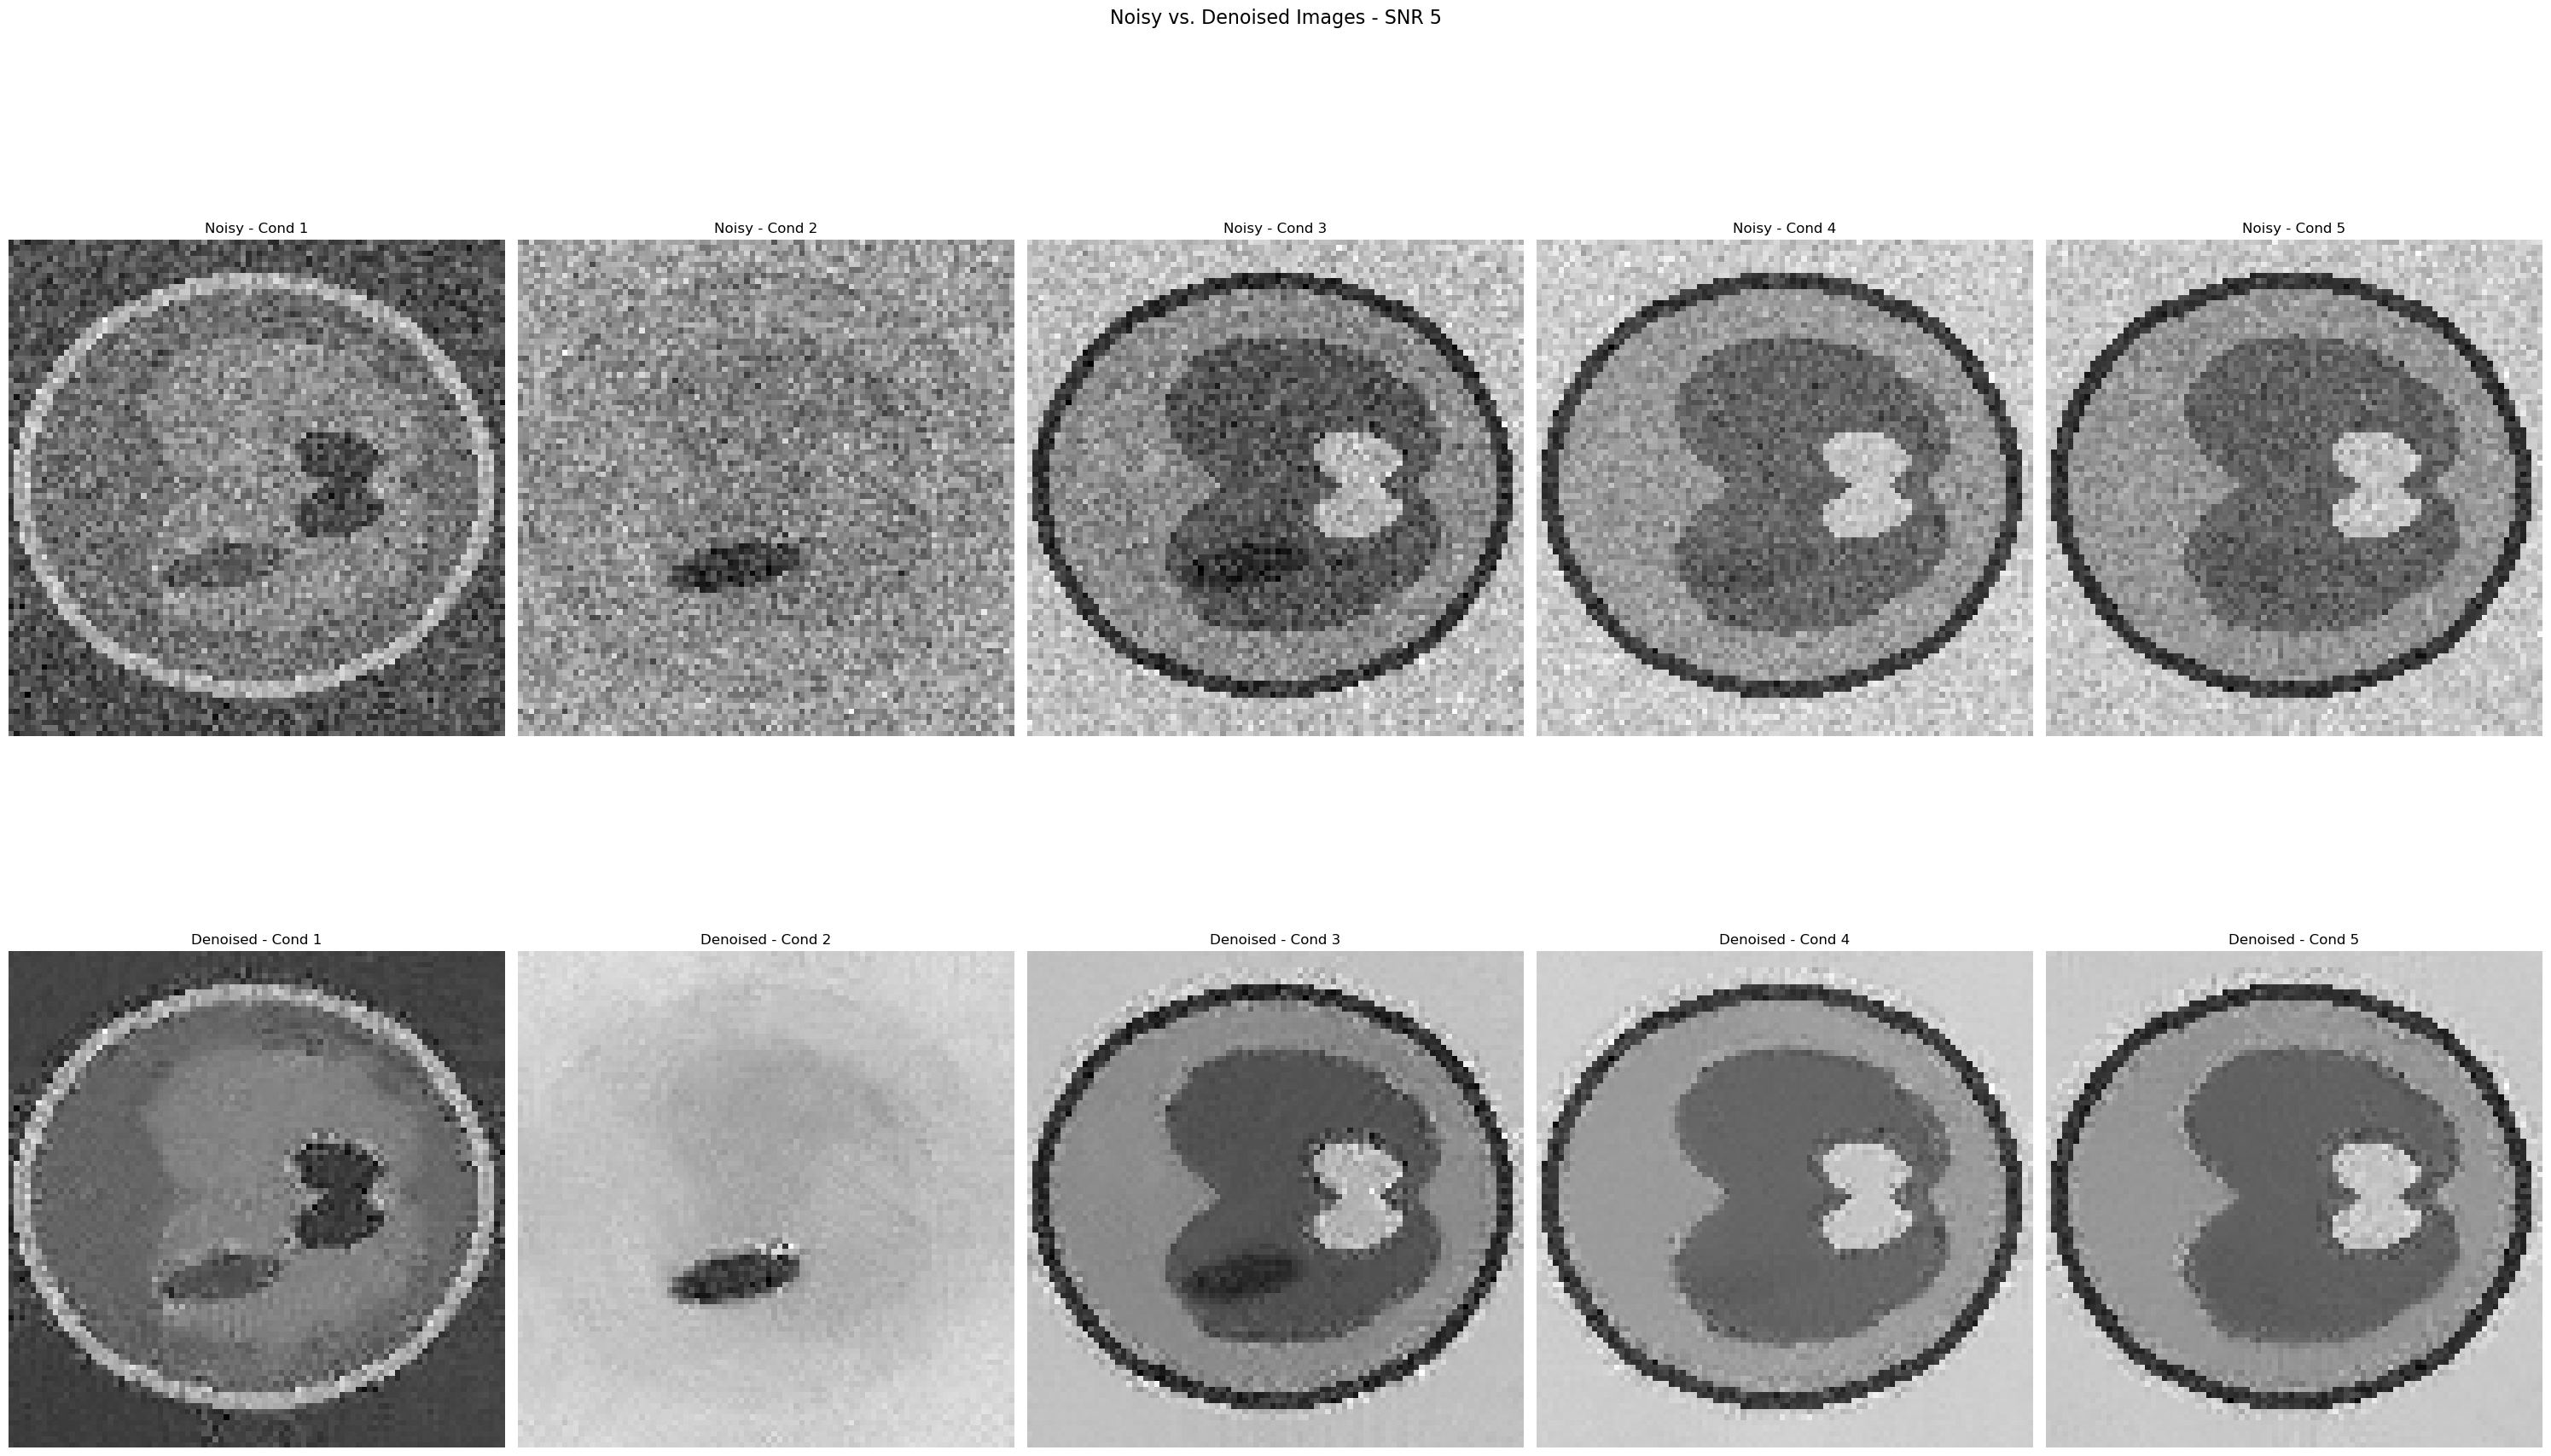

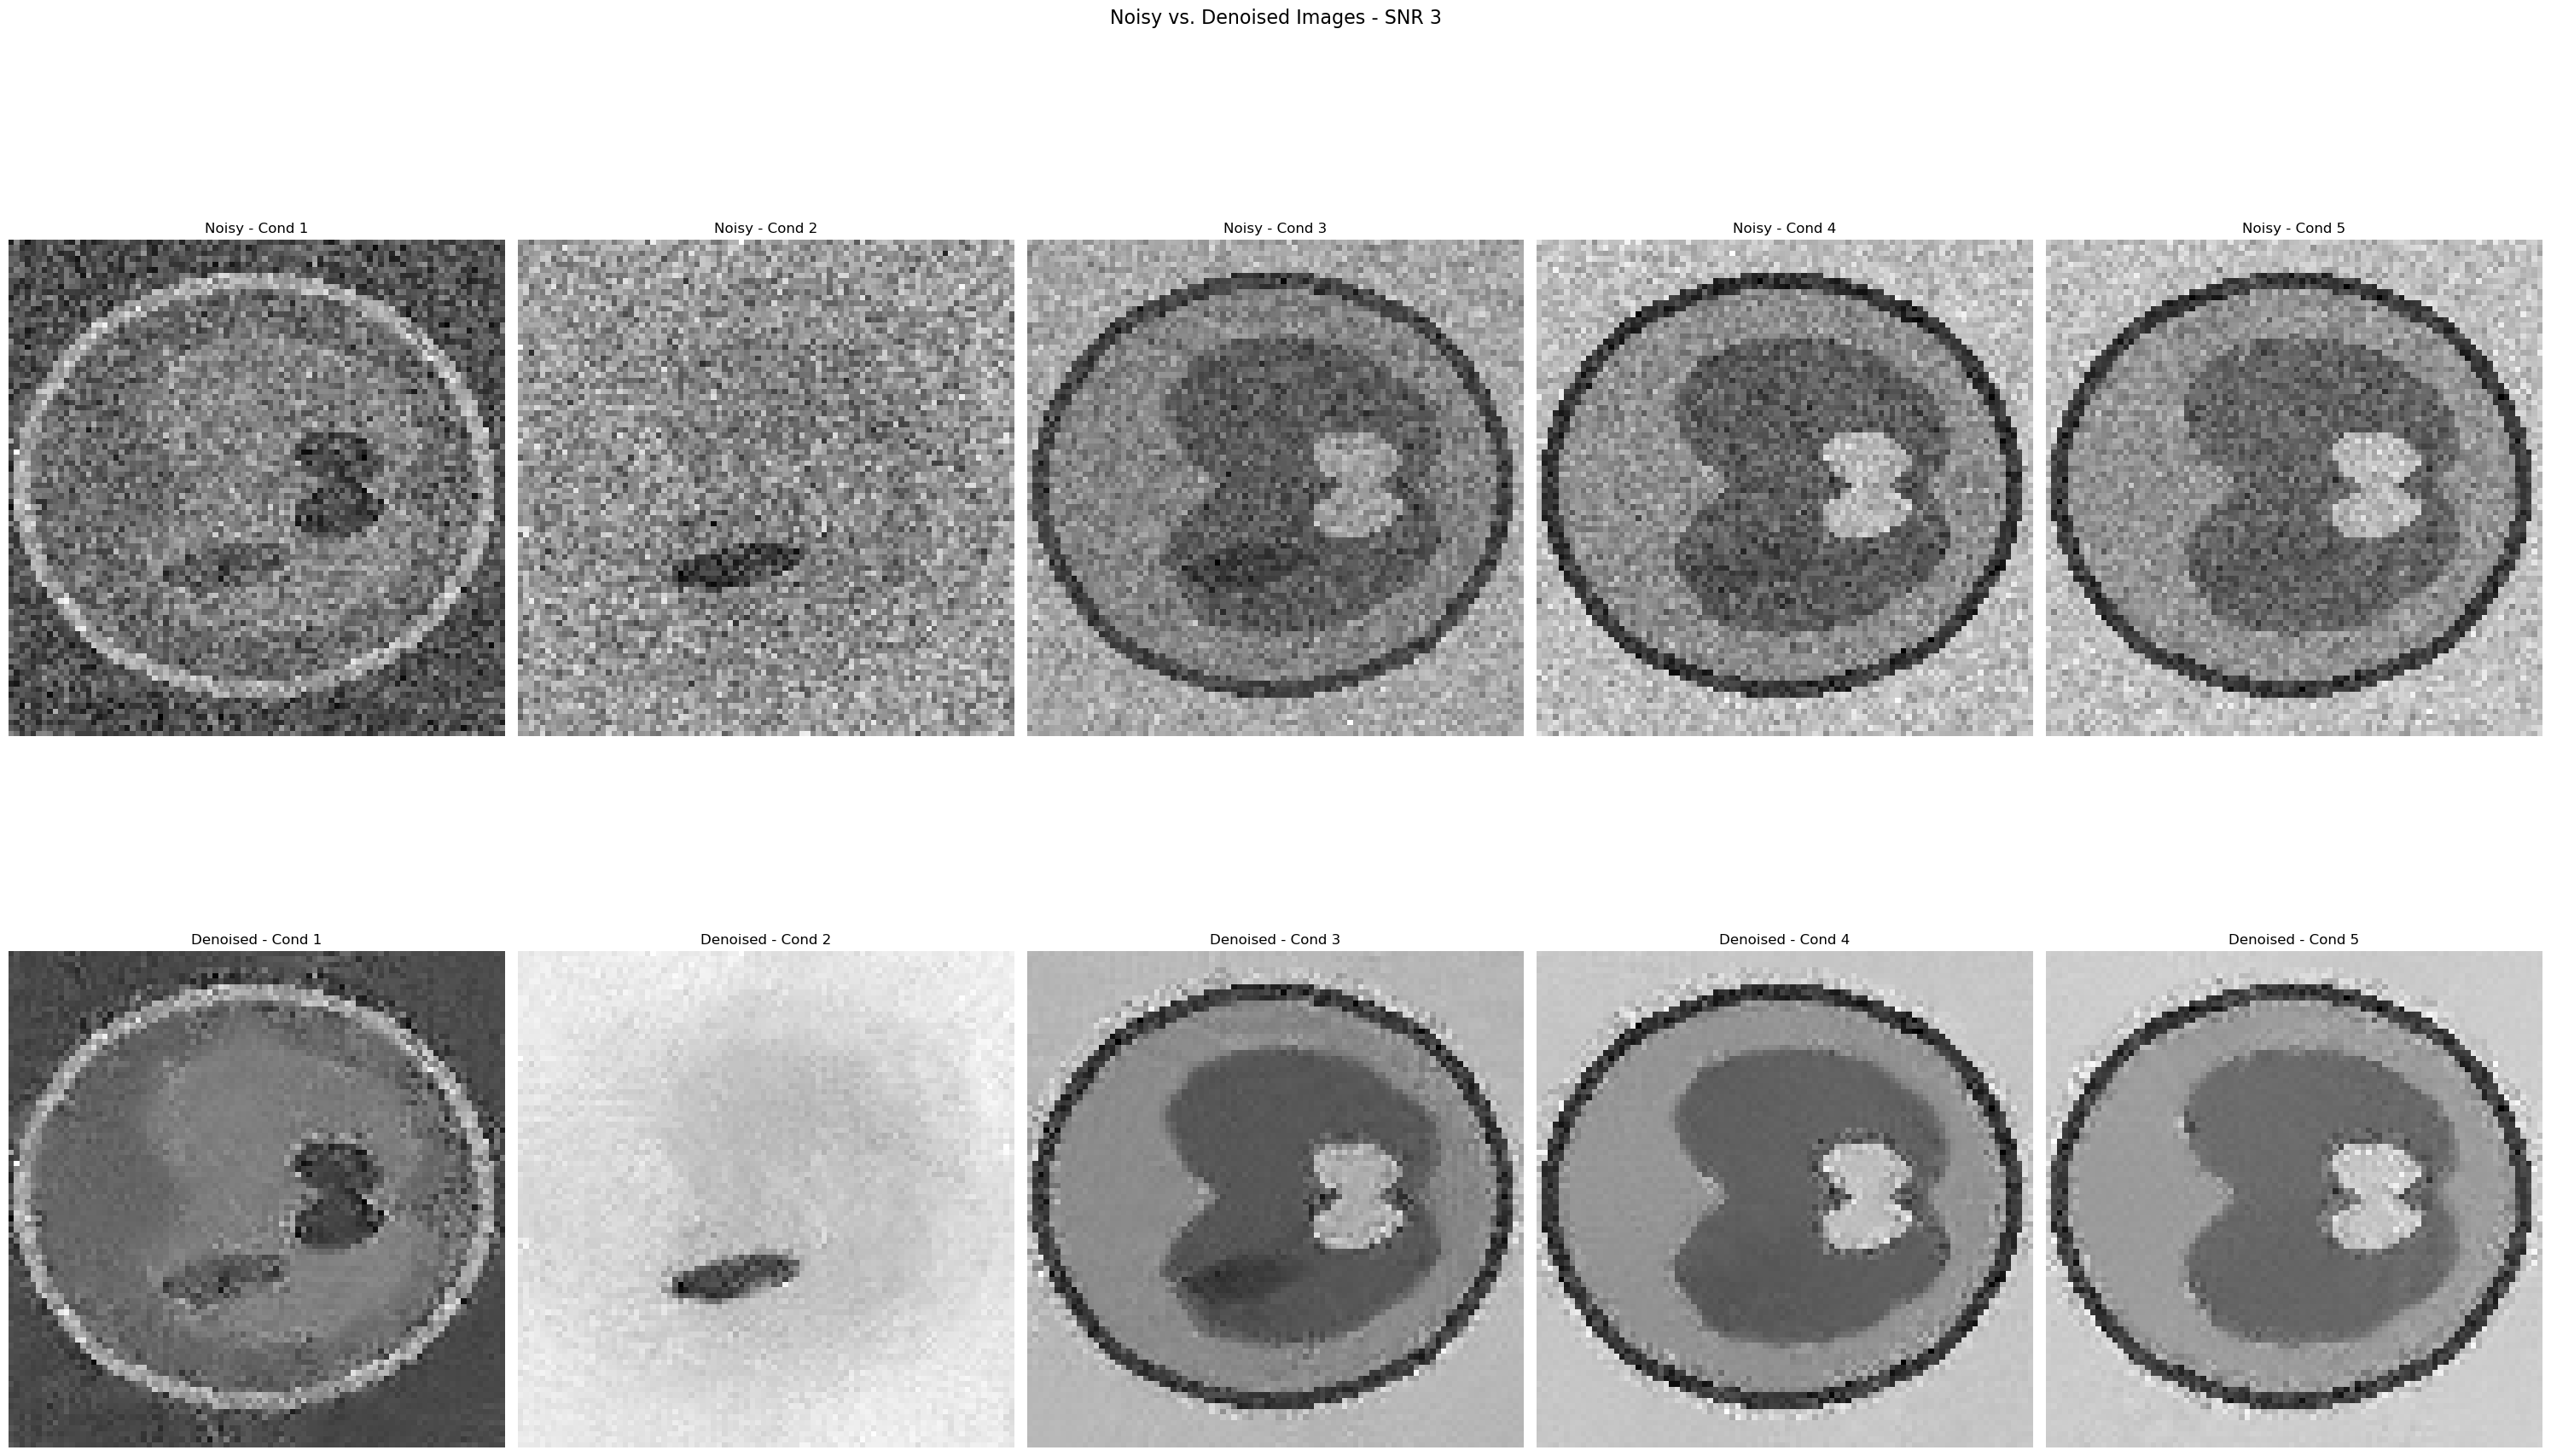

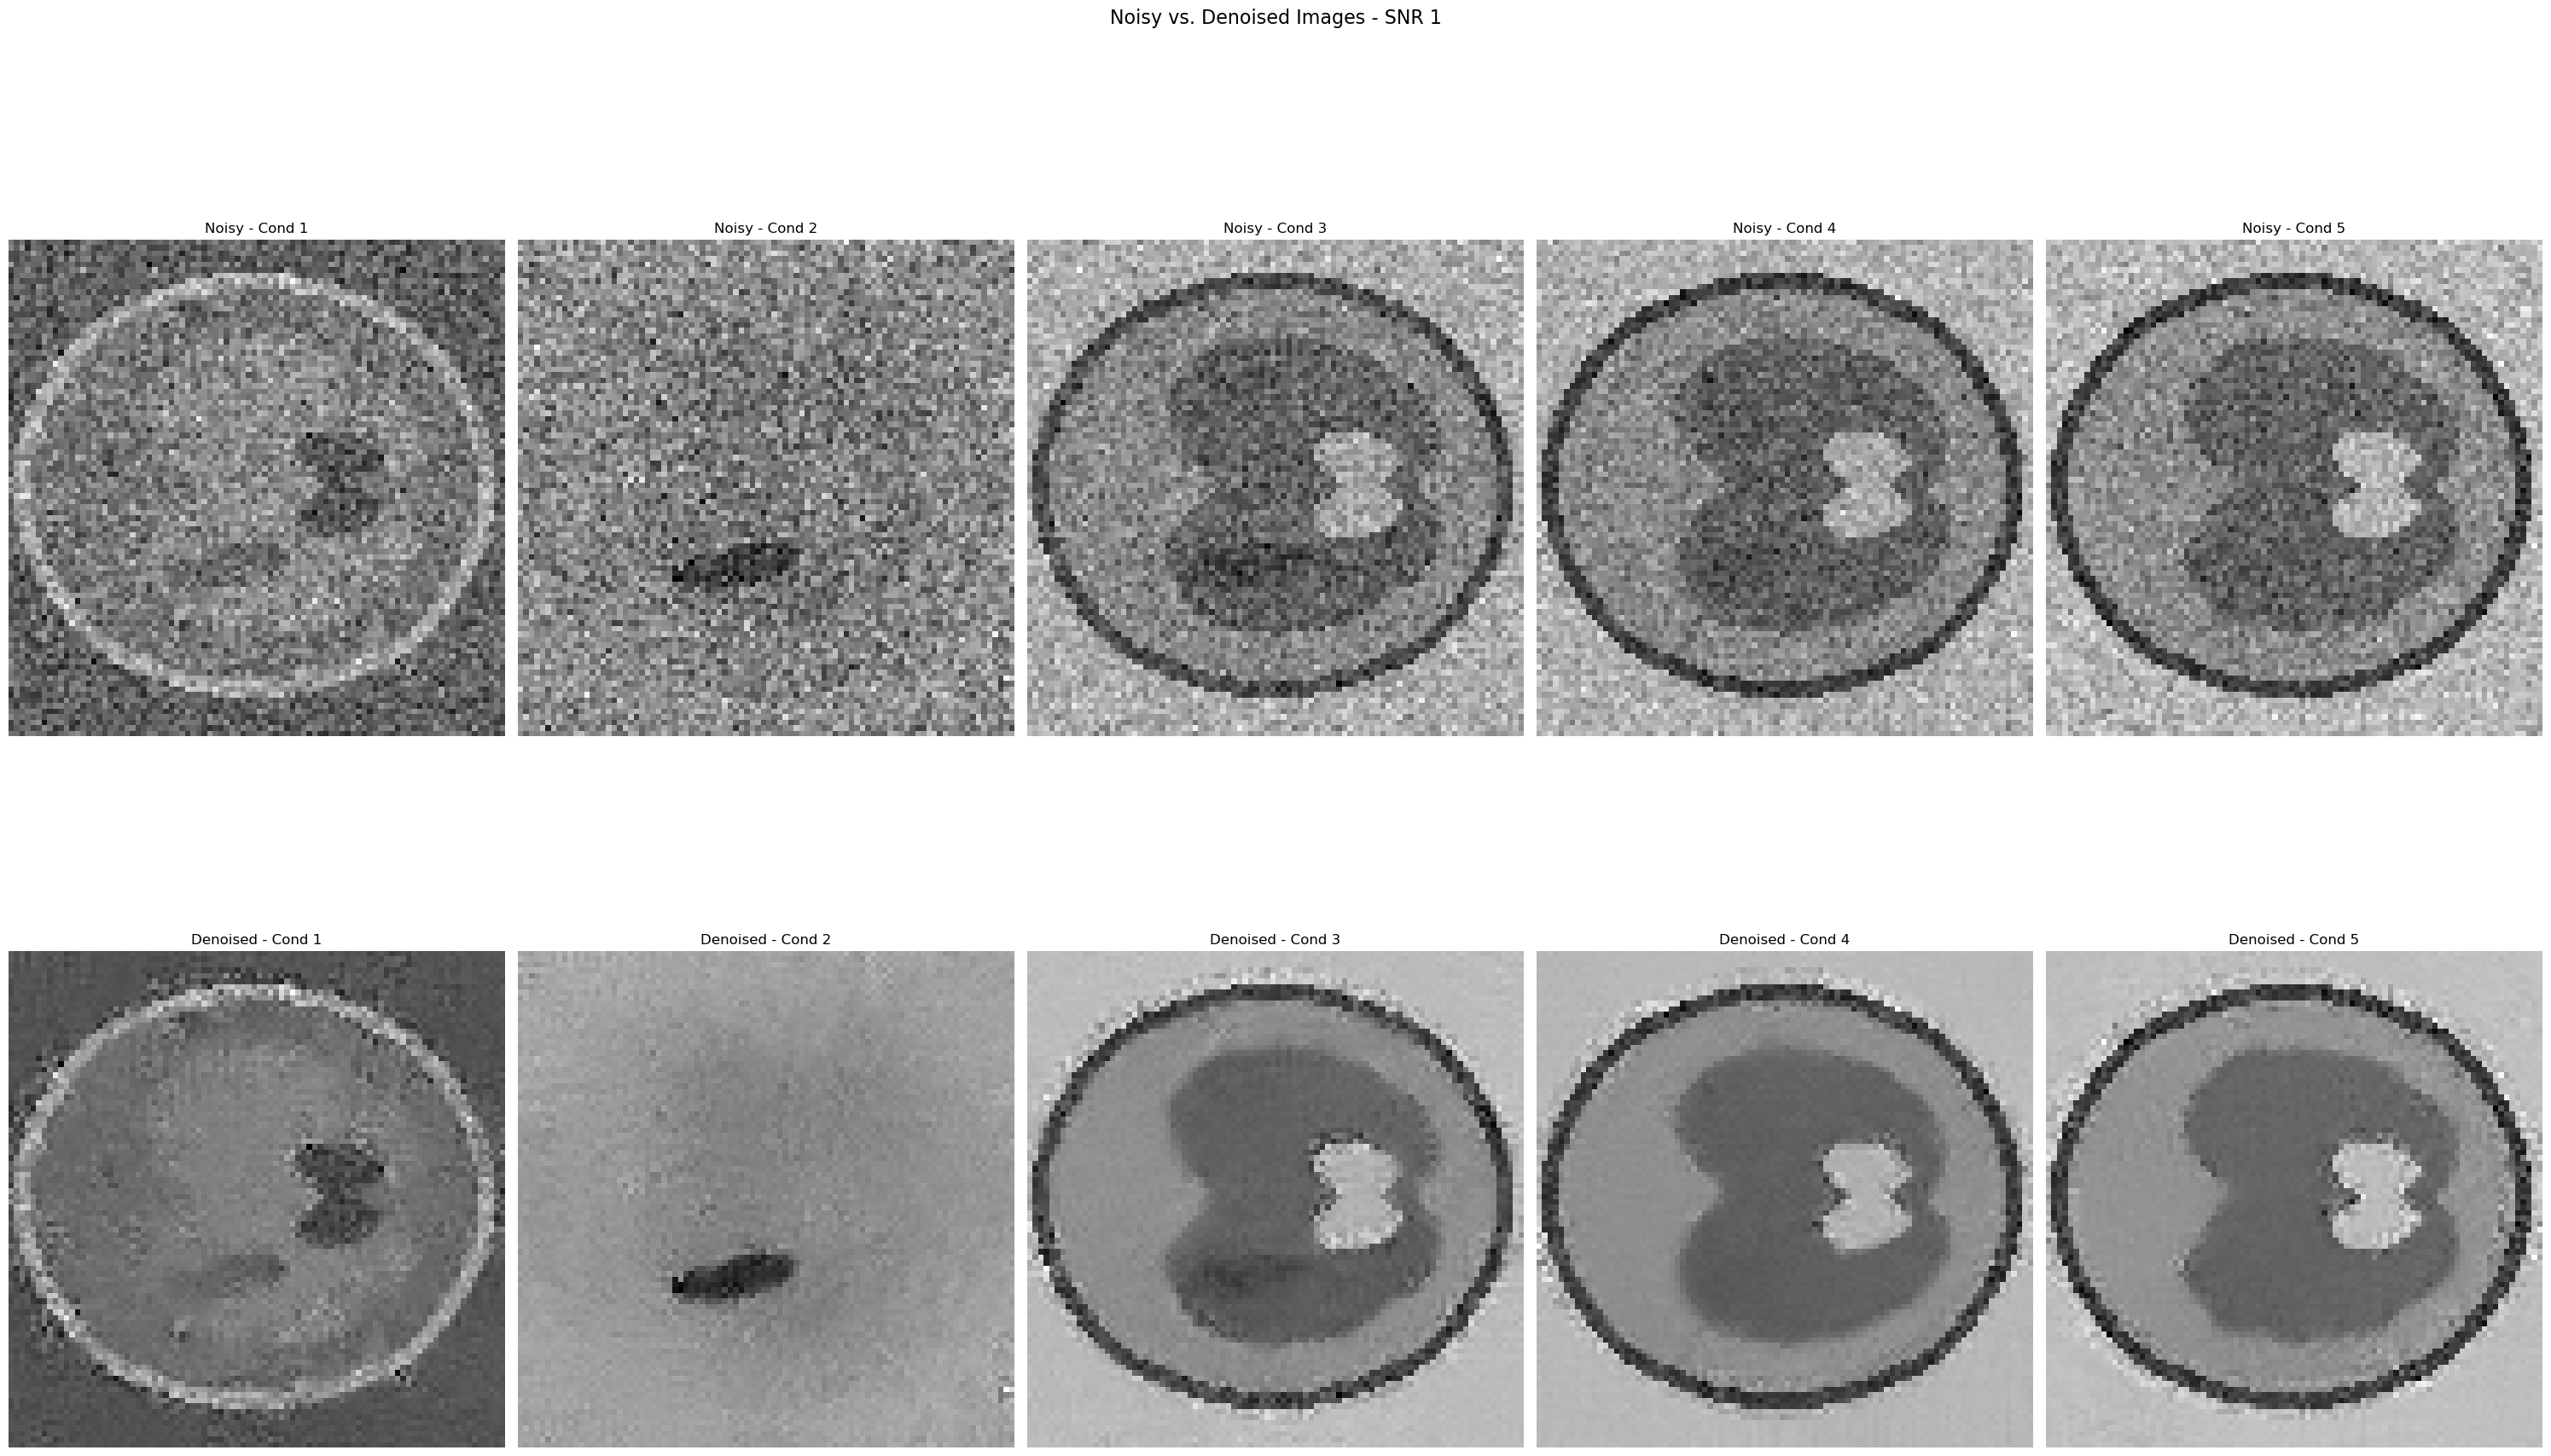

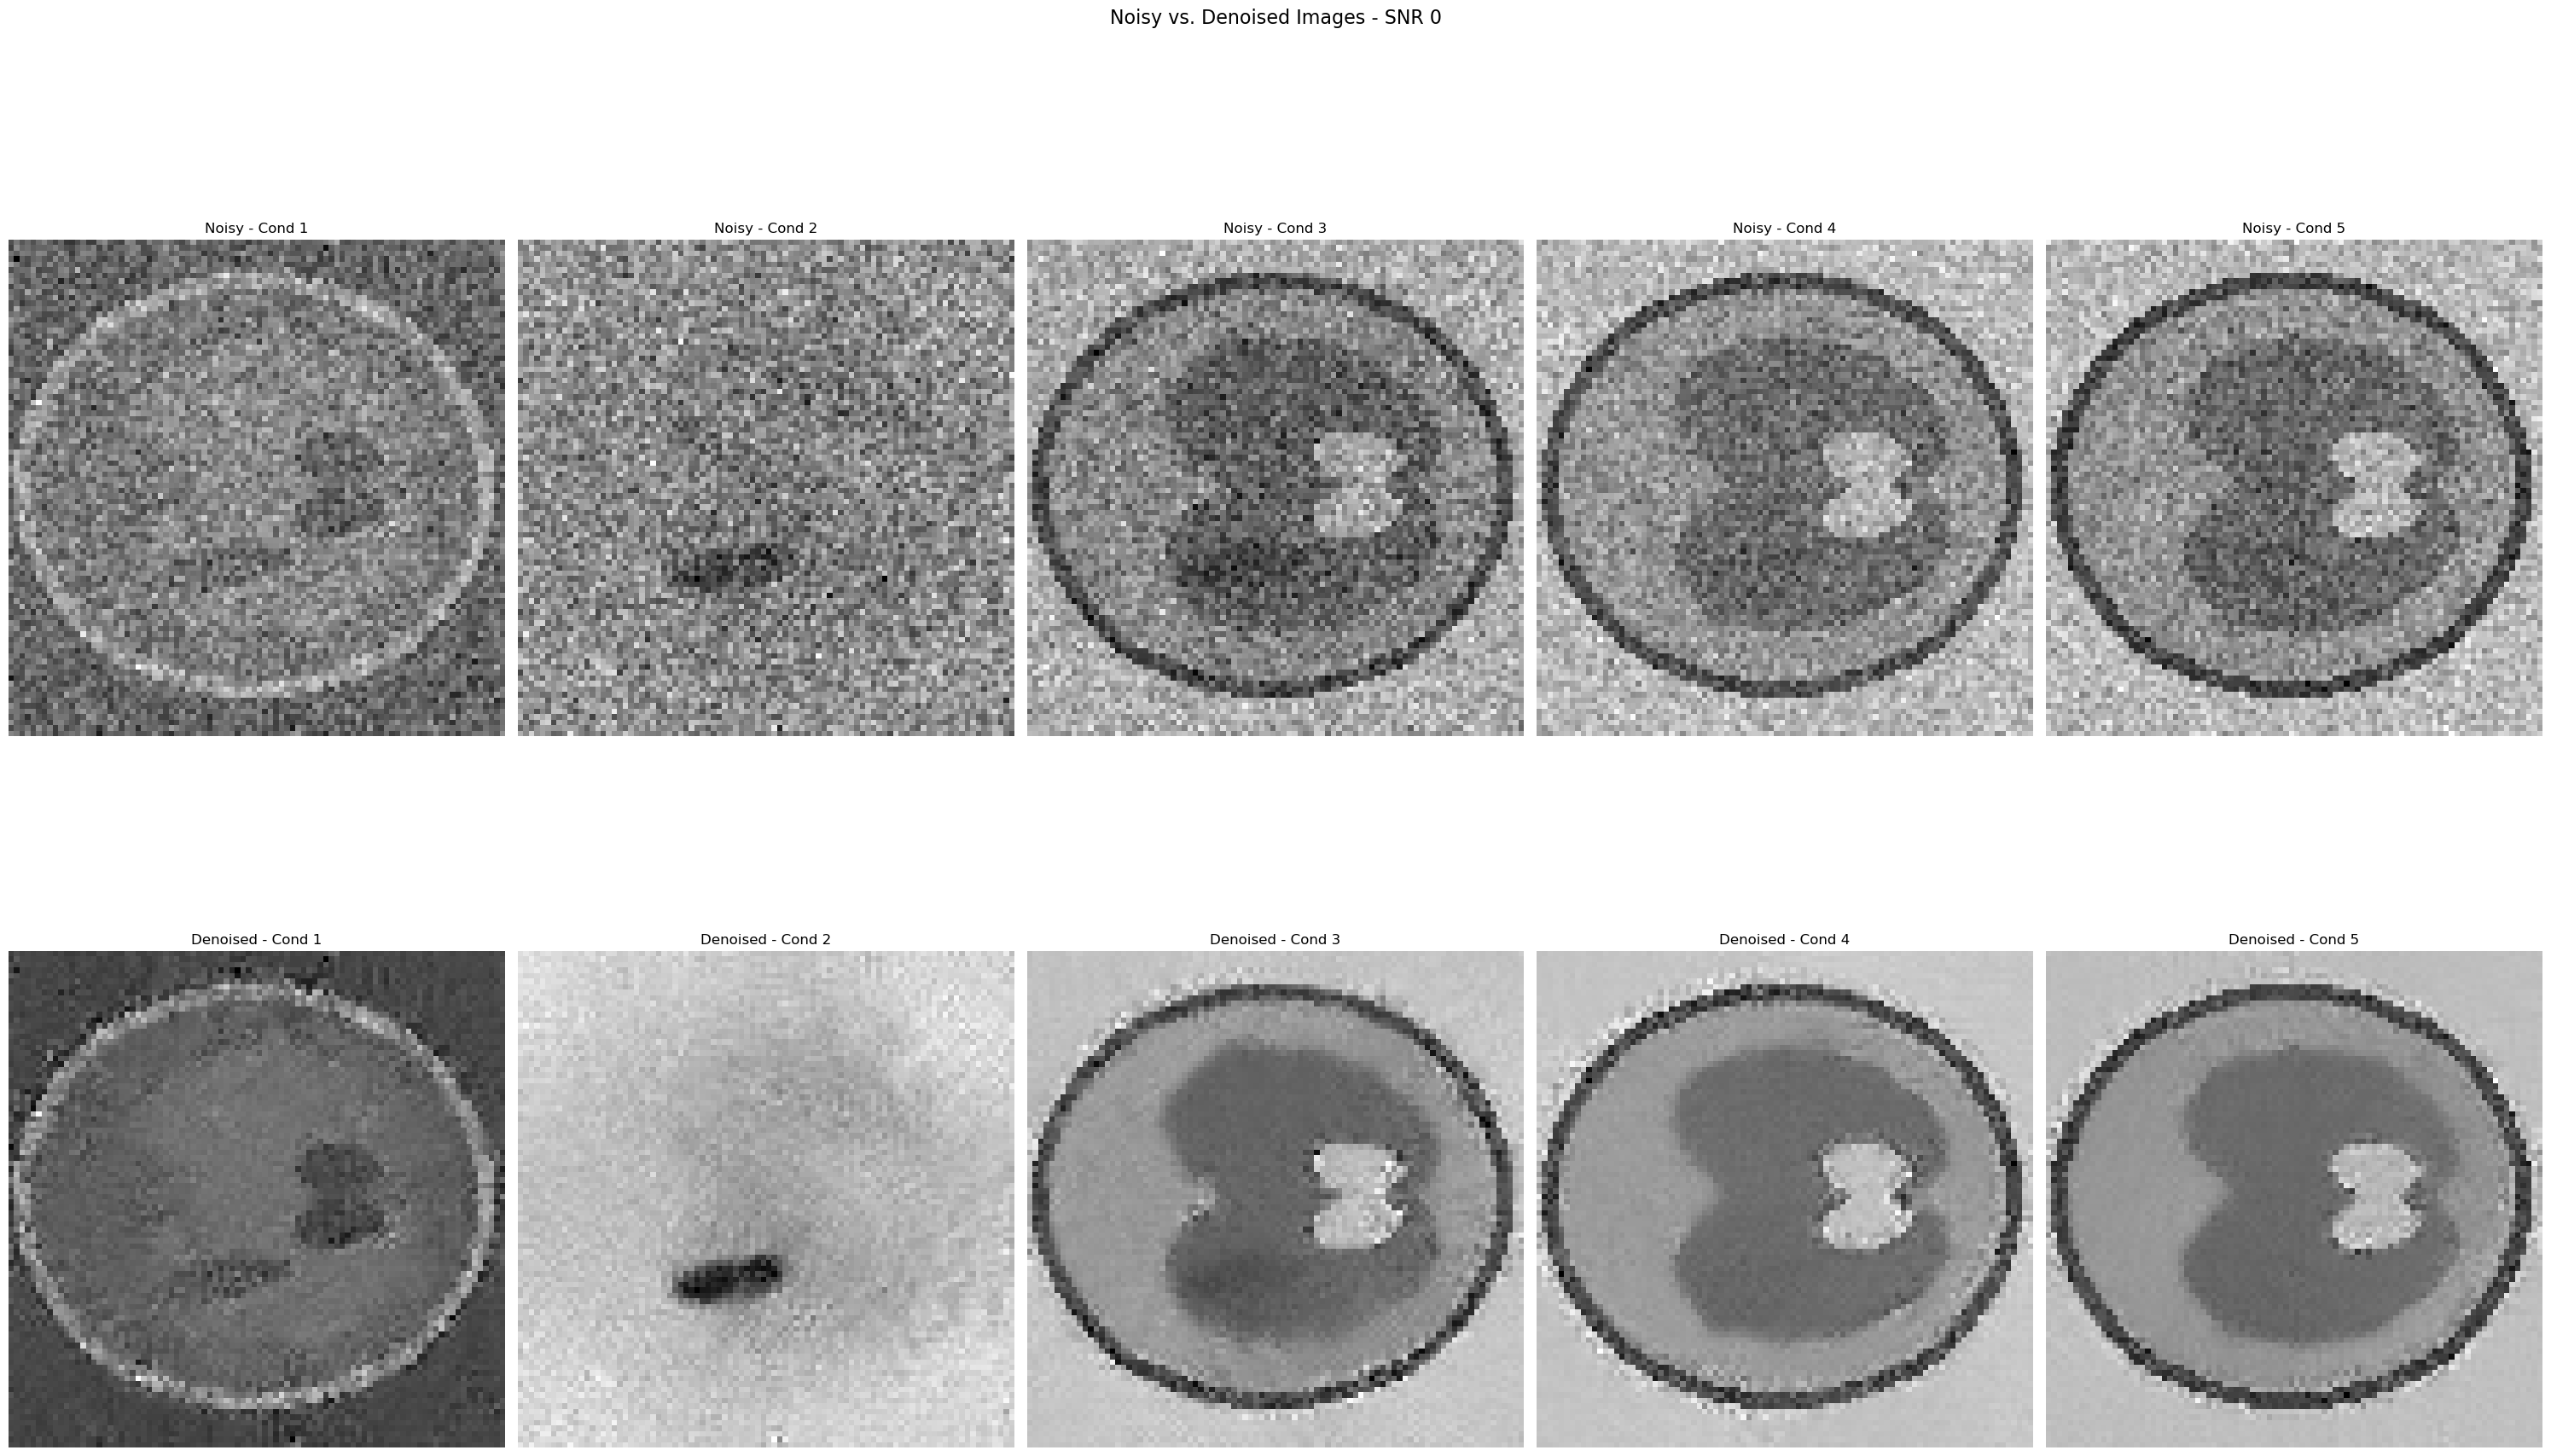

In [29]:
for snr in snrs:
    # Load the MAT file
    mat = scipy.io.loadmat(f'/Users/dolorious/Downloads/simulation-1/GroundTruth_gaussian_SNR{snr}.mat')
    mat_ground_truth = scipy.io.loadmat(f'/Users/dolorious/Downloads/simulation-1/GroundTruth.mat')
    
    ground_truth_data = mat_ground_truth['data']
    

    # Extract noisy image data for the specified SNR
    noisy_image_data = mat['data_gaussian']
    

    plt.figure(figsize=(30, 20))  # Adjust the figure size as needed.

    conditions = noisy_image_data.shape[2]  # Assuming this represents different conditions.
    for j in range(conditions):
        # Extract the noisy image for the jth condition.
        noisy_image = noisy_image_data[:, :, j].squeeze()
        ground_truth= ground_truth_data[:, :, j]
        
        
        # Check if the image has three channels (RGB), and convert to grayscale if so
        if noisy_image.ndim == 3 and noisy_image.shape[2] == 3:
            noisy_image_gray = noisy_image.mean(axis=2)
        else:
            # If the image is already grayscale or doesn't meet the RGB shape assumption
            noisy_image_gray = noisy_image

        # Estimate the noise standard deviation from the image
        sigma_est = np.mean(estimate_sigma(noisy_image))

        # Dynamically adjust denoising parameters based on estimated noise level
        h, patch_size, patch_distance = adjust_denoising_parameters(sigma_est)

        # Create a mask to isolate the background
        background_mask = create_background_mask(noisy_image_gray)

        # Calculate the standard deviation of background pixels
        std_deviation = np.std(noisy_image_gray[background_mask])
        
        ground_truth_gray = rgb2gray(ground_truth)

        # Apply Non-Local Means Denoising with dynamically adjusted parameters
        denoised_image = denoise_nl_means(noisy_image_gray, h=h, patch_size=patch_size,
                                          patch_distance=patch_distance)

        # Plot Noisy Image in the top row
        plt.subplot(2, conditions, j + 1)
        plt.imshow(noisy_image_gray, cmap='gray')
        plt.title(f'Noisy - Cond {j+1}')
        plt.axis('off')

        # Plot Denoised Image in the bottom row
        plt.subplot(2, conditions, conditions + j + 1)
        plt.imshow(denoised_image, cmap='gray')
        plt.title(f'Denoised - Cond {j+1}')
        plt.axis('off')

    plt.suptitle(f'Noisy vs. Denoised Images - SNR {snr}', fontsize=16)
    plt.tight_layout()
    plt.show()


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

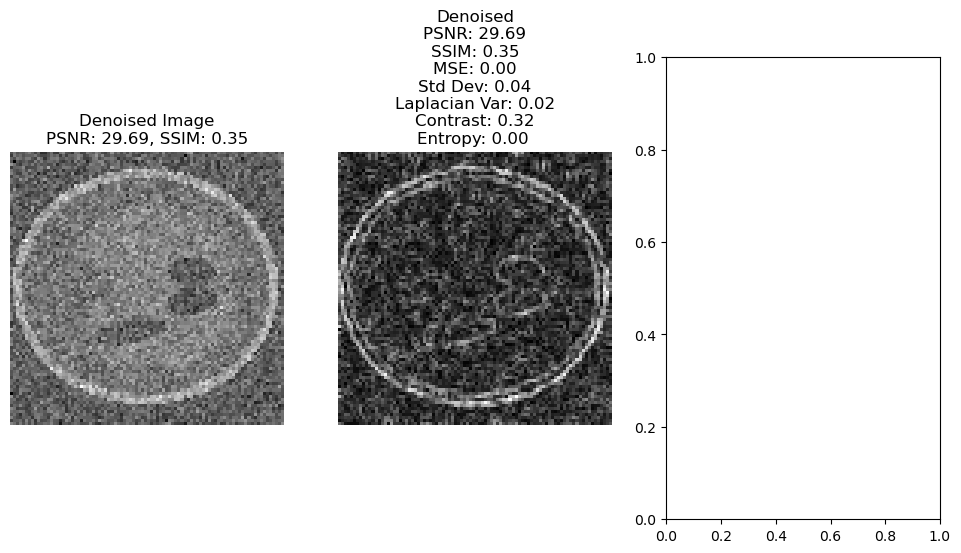

In [12]:
image_ssim = ssim(ground_truth_gray, denoised_image, data_range=denoised_image.max() - denoised_image.min())
image_psnr = psnr(ground_truth_gray, denoised_image)
image_mse = mse(ground_truth_gray, denoised_image)
nr_iqa_metrics = compute_nr_iqa(denoised_image)
edges = sobel(denoised_image)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(denoised_image, cmap='gray')
plt.title(f'Denoised Image\nPSNR: {image_psnr:.2f}, SSIM: {image_ssim:.2f}')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(edges, cmap='gray')
plt.title(f'Denoised\nPSNR: {image_psnr:.2f}\nSSIM: {image_ssim:.2f}\nMSE: {image_mse:.2f}\nStd Dev: {nr_iqa_metrics["Standard Deviation"]:.2f}\nLaplacian Var: {nr_iqa_metrics["Laplacian Variance"]:.2f}\nContrast: {nr_iqa_metrics["Contrast (Michelson)"]:.2f}\nEntropy: {nr_iqa_metrics["Entropy"]:.2f} ')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.bar(range(len(nr_iqa_metrics)), list(nr_iqa_metrics.values()), align='center')
plt.xticks(range(len(nr_iqa_metrics)), list(nr_iqa_metrics.keys()), rotation=45)
plt.title('NR-IQA Metrics')
plt.tight_layout()

plt.suptitle(f'Quality Metrics and Edge Detection - SNR {snr} - Condition {j+1}', fontsize=14)
plt.show()



/var/folders/vl/tld4y4295dvbpfhgzk8mrvkc0000gn/T/ipykernel_66587/2199206993.py:122: UserWarning: image is size 3 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  sigma_est = np.mean(estimate_sigma(noisy_image))


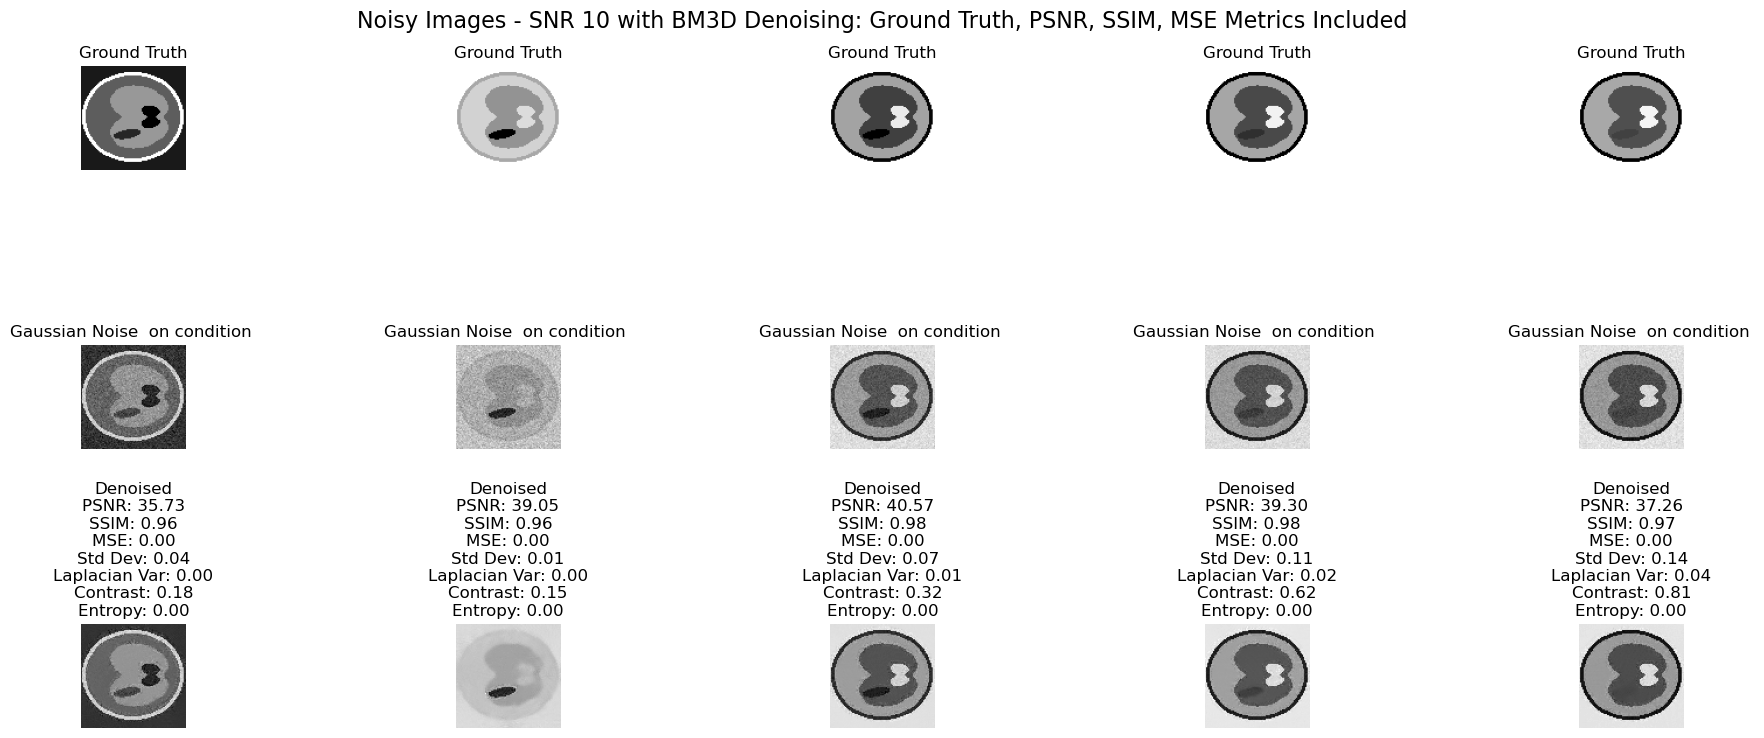

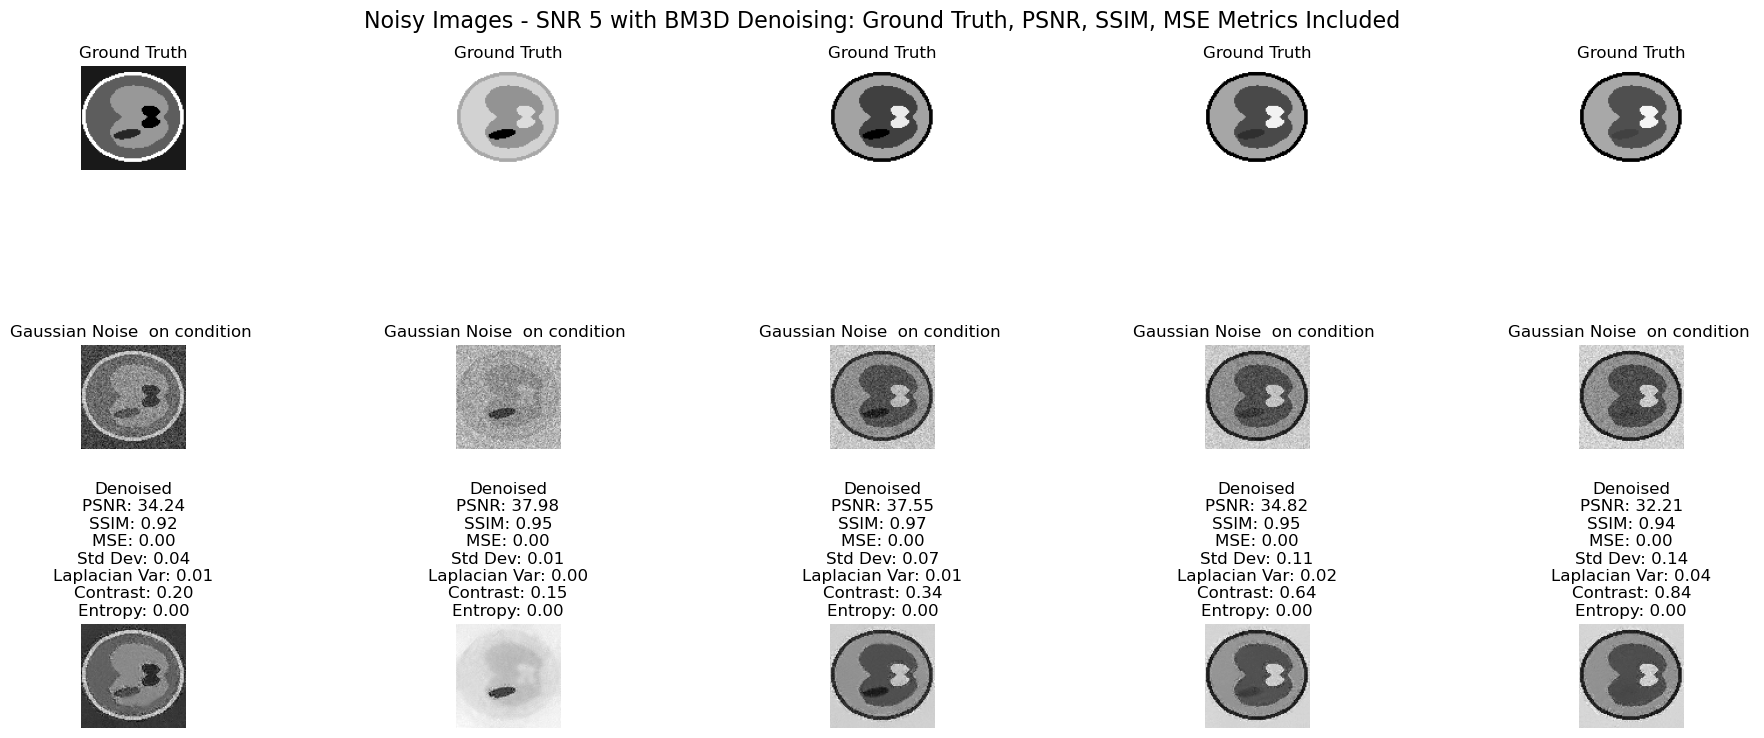

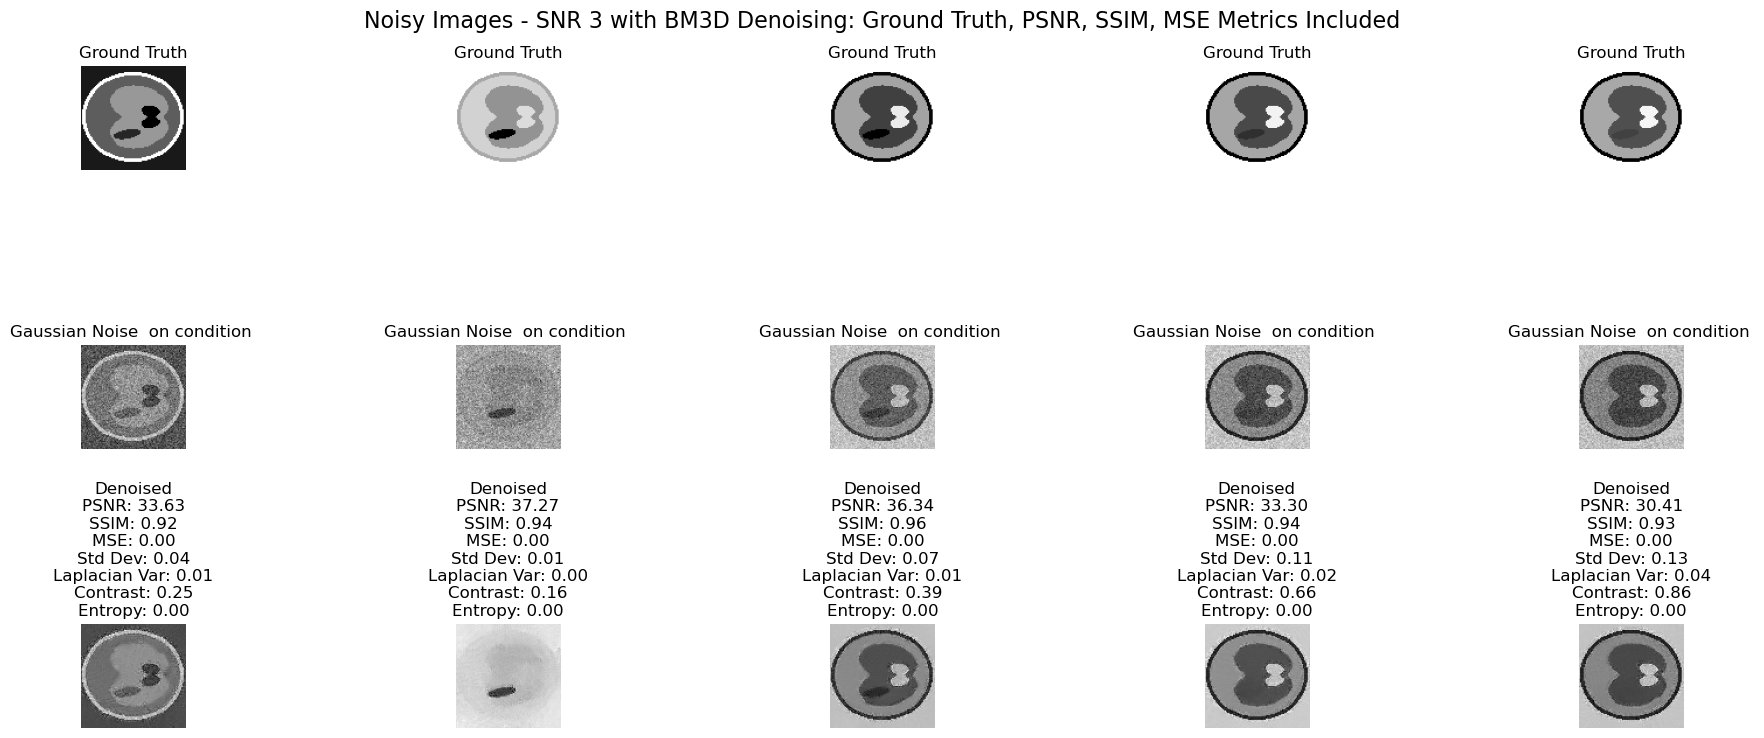

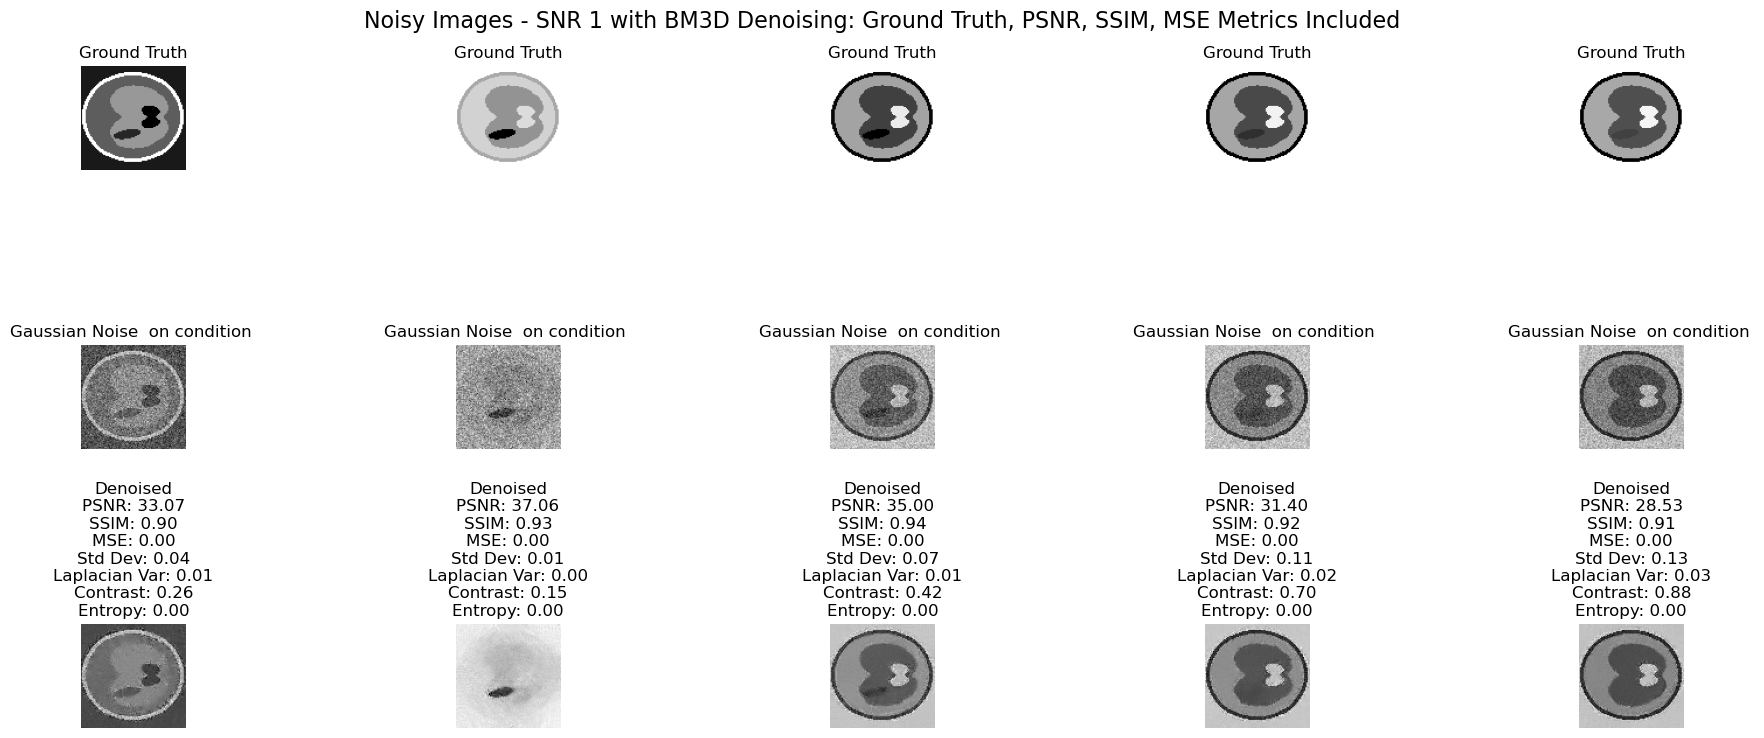

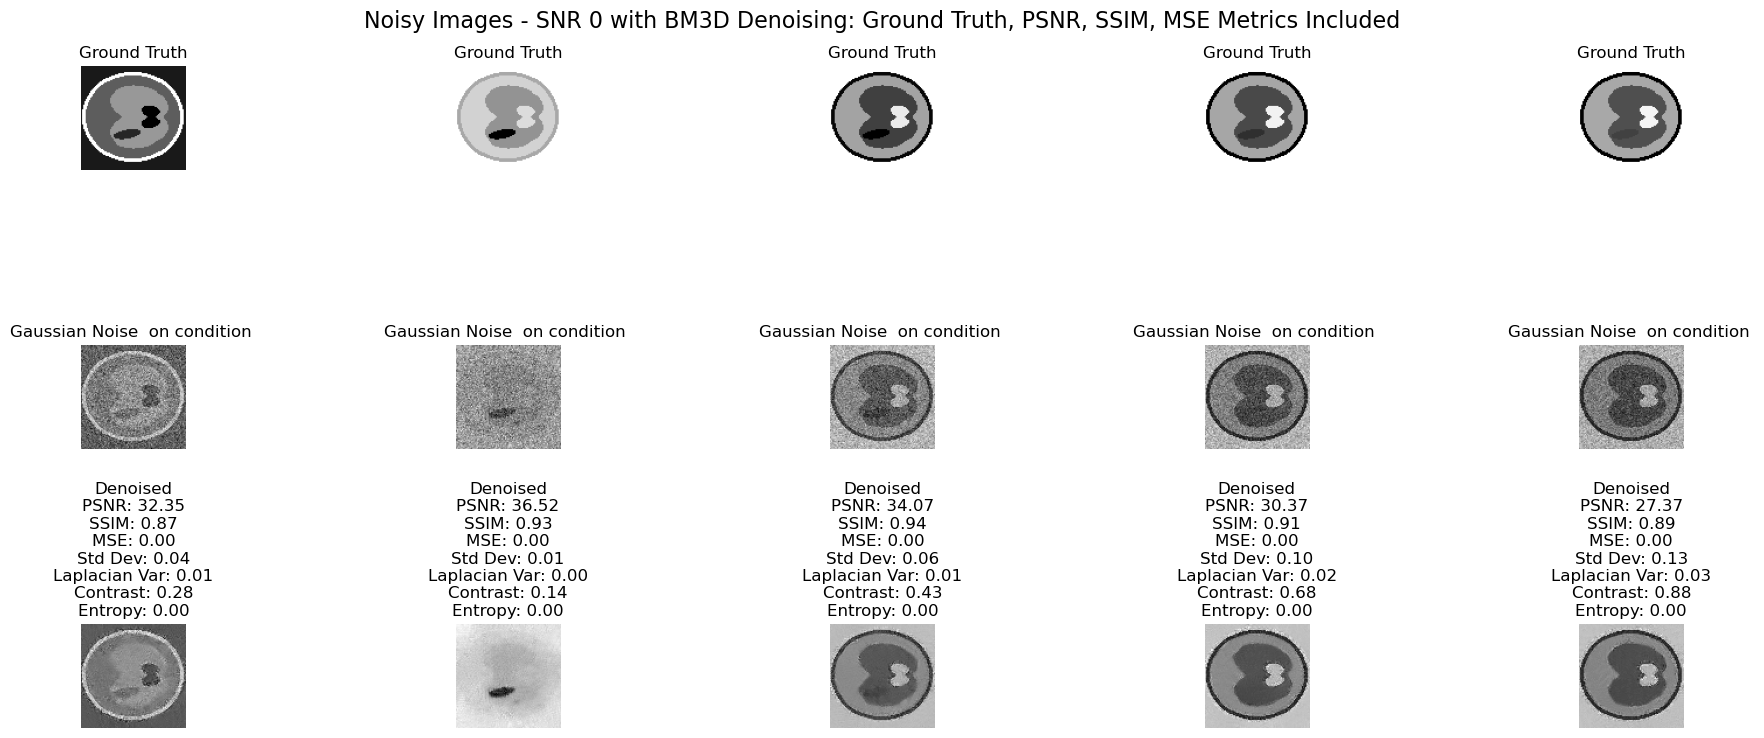

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import estimate_sigma, denoise_nl_means
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from scipy.stats import entropy as scipy_entropy
from skimage.filters import laplace
from skimage.color import rgb2gray
import os
import scipy.io
import scipy.io

def create_background_mask(image_gray):
    # Use Otsu's method to automatically determine a threshold for binarization
    thresh = threshold_otsu(image_gray)

    # Binarize the image based on the determined threshold
    binary_image = image_gray <= thresh

    # Remove small objects and clear borders
    cleared_image = clear_border(binary_image)

    # Label connected components
    label_image = label(cleared_image)

    # Find properties of labeled regions
    regions = regionprops(label_image)

    # Find the largest region (assuming it's the background)
    largest_area = 0
    background_label = 0
    for region in regions:
        if region.area > largest_area:
            largest_area = region.area
            background_label = region.label

    # Create a mask for the background region
    background_mask = label_image == background_label

    return background_mask


def compute_nr_iqa(image):
    """
    Calculates no-reference image quality assessment (NR-IQA) features for a given image.

    Args:
        image (np.ndarray): The grayscale image for which to calculate NR-IQA features.

    Returns:
        dict: A dictionary containing the calculated NR-IQA features:
            - Standard Deviation: Standard deviation of pixel intensity values.
            - Laplacian Variance: Variance of the Laplacian filter applied to the image.
            - Contrast (Michelson): Michelson contrast measure based on minimum and maximum intensities.
            - Entropy: Image entropy calculated using skimage.metrics.entropy.
    """

    std_dev = np.std(image)
    laplacian_img = laplace(image, ksize=3)  # Apply the Laplacian filter
    laplacian_var = np.var(laplacian_img)  # Compute the variance of the Laplacian
    contrast = (np.max(image) - np.min(image)) / (np.max(image) + np.min(image))
    # Calculate global entropy
    hist, _ = np.histogram(image, bins=256, range=(0, 256))
    prob_dist = hist / np.sum(hist)
    entropy_val = scipy_entropy(prob_dist, base=2)

    return {
        'Standard Deviation': std_dev,
        'Laplacian Variance': laplacian_var,
        'Contrast (Michelson)': contrast,
        'Entropy': entropy_val,
    }


# Define the specific SNRs to display
snrs = [10, 5, 3, 1, 0]  

def adjust_denoising_parameters(sigma_est):
    if sigma_est <= 15:
        return 0.6 * sigma_est, 7, 11  # h, patch_size, patch_distance
    elif sigma_est <= 30:
        return 0.9 * sigma_est, 5, 6
    elif sigma_est <= 50:
        return 0.2 * sigma_est, 9, 17
    else:
        return 0.4 * sigma_est, 11, 23

# Iterate over each SNR
for snr in snrs:
    # Load the MAT file
    mat = scipy.io.loadmat(f'/Users/dolorious/Downloads/simulation-1/GroundTruth_rician_SNR{snr}.mat')
    mat_ground_truth = scipy.io.loadmat(f'/Users/dolorious/Downloads/simulation-1/GroundTruth.mat')
    
    ground_truth_data = mat_ground_truth['data']
    

    # Extract noisy image data for the specified SNR
    noisy_image_data = mat['data_rician']
    

    plt.figure(figsize=(20, 8))  # Adjust the figure size as needed.

    conditions = noisy_image_data.shape[2]  # Assuming this represents different conditions.
    for j in range(conditions):
        # Extract the noisy image for the jth condition.
        noisy_image = noisy_image_data[:, :, j].squeeze()
        ground_truth= ground_truth_data[:, :, j]
        
        
        # Check if the image has three channels (RGB), and convert to grayscale if so
        if noisy_image.ndim == 3 and noisy_image.shape[2] == 3:
            noisy_image_gray = noisy_image.mean(axis=2)
        else:
            # If the image is already grayscale or doesn't meet the RGB shape assumption
            noisy_image_gray = noisy_image

        # Estimate the noise standard deviation from the image
        sigma_est = np.mean(estimate_sigma(noisy_image))

        # Dynamically adjust denoising parameters based on estimated noise level
        h, patch_size, patch_distance = adjust_denoising_parameters(sigma_est)

        # Create a mask to isolate the background
        background_mask = create_background_mask(noisy_image_gray)

        # Calculate the standard deviation of background pixels
        std_deviation = np.std(noisy_image_gray[background_mask])
        
        ground_truth_gray = rgb2gray(ground_truth)

        # Apply Non-Local Means Denoising with dynamically adjusted parameters
        denoised_image = denoise_nl_means(noisy_image_gray, h=h, patch_size=patch_size,
                                          patch_distance=patch_distance)
        
        
        
        
        image_ssim = ssim(ground_truth_gray, denoised_image, data_range=1.0)
        image_psnr = psnr(ground_truth_gray, denoised_image)
        image_mse = mse(ground_truth_gray, denoised_image)
        nr_iqa_metrics = compute_nr_iqa(denoised_image)
        
         # Save the noisy and denoised images
       
        plt.imsave(f"../TraditionalMethods/Experiments/DenoisedImages/denoised_snr{snr}_condition{j+1}.tiff", denoised_image, cmap='gray')
 
        
        
        

        plt.subplot(3, conditions, j + 1)
        plt.imshow(ground_truth_gray, cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')
        
        # Noisy Image
        plt.subplot(3, conditions, j + 1 + conditions)
        plt.imshow(noisy_image_gray, cmap='gray')
        plt.title(f'Gaussian Noise  on condition ')
        plt.axis('off')
        
        # Denoised Image
        plt.subplot(3, conditions, j + 1 + 2*conditions)
        plt.imshow(denoised_image, cmap='gray')
        plt.title(f'Denoised\nPSNR: {image_psnr:.2f}\nSSIM: {image_ssim:.2f}\nMSE: {image_mse:.2f}\nStd Dev: {nr_iqa_metrics["Standard Deviation"]:.2f}\nLaplacian Var: {nr_iqa_metrics["Laplacian Variance"]:.2f}\nContrast: {nr_iqa_metrics["Contrast (Michelson)"]:.2f}\nEntropy: {nr_iqa_metrics["Entropy"]:.2f}')
        plt.axis('off')

    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.88)
    plt.suptitle(f'Noisy Images - SNR {snr} with BM3D Denoising: Ground Truth, PSNR, SSIM, MSE Metrics Included', fontsize=16, y=0.95)
    plt.show()

  
  



In [1]:
 pip install --upgrade pip

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/8a/6a/19e9fe04fca059ccf770861c7d5721ab4c2aebc539889e97c7977528a53b/pip-24.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.8 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1
Note: you may need to restart the kernel to use updated packages.


/var/folders/vl/tld4y4295dvbpfhgzk8mrvkc0000gn/T/ipykernel_7383/19716309.py:74: UserWarning: image is size 3 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  sigma_est = np.mean(estimate_sigma(noisy_image))


NameError: name 'std_deviation_denoised' is not defined

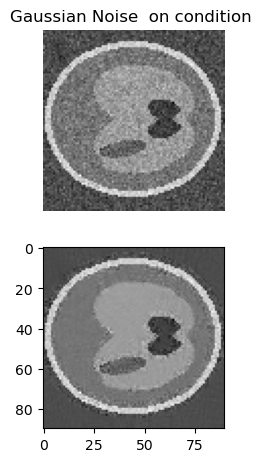

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import estimate_sigma, denoise_nl_means
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
import scipy.io

def create_background_mask(image_gray):
    # Use Otsu's method to automatically determine a threshold for binarization
    thresh = threshold_otsu(image_gray)

    # Binarize the image based on the determined threshold
    binary_image = image_gray <= thresh

    # Remove small objects and clear borders
    cleared_image = clear_border(binary_image)

    # Label connected components
    label_image = label(cleared_image)

    # Find properties of labeled regions
    regions = regionprops(label_image)

    # Find the largest region (assuming it's the background)
    largest_area = 0
    background_label = 0
    for region in regions:
        if region.area > largest_area:
            largest_area = region.area
            background_label = region.label

    # Create a mask for the background region
    background_mask = label_image == background_label

    return background_mask

# Define the specific SNRs to display
snrs = [10, 5, 3, 1, 0]  

def adjust_denoising_parameters(sigma_est):
    if sigma_est <= 15:
        return 0.6 * sigma_est, 7, 11  # h, patch_size, patch_distance
    elif sigma_est <= 30:
        return 0.9 * sigma_est, 5, 6
    elif sigma_est <= 50:
        return 0.2 * sigma_est, 9, 17
    else:
        return 0.4 * sigma_est, 11, 23

# Iterate over each SNR
for snr in snrs:
    # Load the MAT file
    mat = scipy.io.loadmat(f'/Users/dolorious/Downloads/simulation-1/GroundTruth_gaussian_SNR{snr}.mat')

    # Extract noisy image data for the specified SNR
    noisy_image_data = mat['data_gaussian']

    plt.figure(figsize=(20, 8))  # Adjust the figure size as needed.

    conditions = noisy_image_data.shape[2]  
    for j in range(conditions):
        # Extract the noisy image for the jth condition.
        noisy_image = noisy_image_data[:, :, j].squeeze()
        
        # Check if the image has three channels (RGB), and convert to grayscale if so
        if noisy_image.ndim == 3 and noisy_image.shape[2] == 3:
            noisy_image_gray = noisy_image.mean(axis=2)
        else:
           
            noisy_image_gray = noisy_image

        # Estimate the noise standard deviation from the image
        sigma_est = np.mean(estimate_sigma(noisy_image))

        # Dynamically adjust denoising parameters based on estimated noise level
        h, patch_size, patch_distance = adjust_denoising_parameters(sigma_est)

        # Create a mask to isolate the background
        background_mask = create_background_mask(noisy_image_gray)

        # Calculate the standard deviation of background pixels
        std_deviation = np.std(noisy_image_gray[background_mask])

        # Apply Non-Local Means Denoising with dynamically adjusted parameters
        denoised_image = denoise_nl_means(noisy_image_gray, h=h, patch_size=patch_size,
                                          patch_distance=patch_distance)
       
        
        # Noisy Image
        plt.subplot(3, conditions, j + 1 + conditions)
        plt.imshow(noisy_image_gray, cmap='gray')
        plt.title(f'Gaussian Noise  on condition ')
        plt.axis('off')
        
        # Denoised Image
        plt.subplot(3, conditions, j + 1 + 2*conditions)
        plt.imshow(denoised_image, cmap='gray')
        plt.title(f'Denoised\nStd Dev: {std_deviation_denoised:.2f}\nPSNR: {image_psnr:.2f}\nSSIM: {image_ssim:.2f}\nMSE: {image_mse:.2f}')
        plt.axis('off')

    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.88)
    plt.suptitle(f'Noisy Images - SNR {snr} with BM3D Denoising: Ground Truth, PSNR, SSIM, MSE Metrics Included', fontsize=16, y=0.95)
    plt.show()

  

